## PC

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from copy import deepcopy
from itertools import combinations, permutations
import numpy as np
import joblib

from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import CITest
from castle.common.priori_knowledge import orient_by_priori_knowledge


class PC(BaseLearner):
    """PC algorithm

    A classic causal discovery algorithm based on conditional independence tests.

    References
    ----------
    [1] original-PC
        https://www.jmlr.org/papers/volume8/kalisch07a/kalisch07a.pdf
    [2] stable-PC
        https://arxiv.org/pdf/1211.3295.pdf
    [3] parallel-PC
        https://arxiv.org/pdf/1502.02454.pdf

    Parameters
    ----------
    variant : str
        A variant of PC-algorithm, one of [`original`, `stable`, `parallel`].
    alpha: float, default 0.05
        Significance level.
    ci_test : str, callable
        ci_test method, if str, must be one of [`fisherz`, `g2`, `chi2`]
        See more: `castle.common.independence_tests.CITest`
    priori_knowledge: PrioriKnowledge
        a class object PrioriKnowledge

    Attributes
    ----------
    causal_matrix : array
        Learned causal structure matrix.

    Examples
    --------
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> from castle.datasets import load_dataset

    >>> X, true_dag, _ = load_dataset(name='IID_Test')
    >>> pc = PC(variant='stable')
    >>> pc.learn(X)
    >>> GraphDAG(pc.causal_matrix, true_dag, save_name='result_pc')
    >>> met = MetricsDAG(pc.causal_matrix, true_dag)
    >>> print(met.metrics)

    >>> pc = PC(variant='parallel')
    >>> pc.learn(X, p_cores=2)
    >>> GraphDAG(pc.causal_matrix, true_dag, save_name='result_pc')
    >>> met = MetricsDAG(pc.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, variant='original', alpha=0.05, ci_test='fisherz',
                 priori_knowledge=None):
        super(PC, self).__init__()
        self.variant = variant
        self.alpha = alpha
        self.ci_test = ci_test
        self.causal_matrix = None
        self.priori_knowledge = priori_knowledge

    def learn(self, data, columns=None, **kwargs):
        """Set up and run the PC algorithm.

        Parameters
        ----------
        data: array or Tensor
            Training data
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        kwargs: [optional]
            p_cores : int
                number of CPU cores to be used
            s : boolean
                memory-efficient indicator
            batch : int
                number of edges per batch
            if s is None or False, or without batch, batch=|J|.
            |J| denote number of all pairs of adjacency vertices (X, Y) in G.
        """

        data = Tensor(data, columns=columns)

        skeleton, sep_set = find_skeleton(data,
                                          alpha=self.alpha,
                                          ci_test=self.ci_test,
                                          variant=self.variant,
                                          priori_knowledge=self.priori_knowledge,
                                          **kwargs)

        self._causal_matrix = Tensor(
            orient(skeleton, sep_set, self.priori_knowledge).astype(int),
            index=data.columns,
            columns=data.columns
        )


def _loop(G, d):
    """
    Check if |adj(x, G)\{y}| < d for every pair of adjacency vertices in G

    Parameters
    ----------
    G: numpy.ndarray
        The undirected graph  G
    d: int
        depth of conditional vertices

    Returns
    -------
    out: bool
        if False, denote |adj(i, G)\{j}| < d for every pair of adjacency
        vertices in G, then finished loop.
    """

    assert G.shape[0] == G.shape[1]

    pairs = [(x, y) for x, y in combinations(set(range(G.shape[0])), 2)]
    less_d = 0
    for i, j in pairs:
        adj_i = set(np.argwhere(G[i] != 0).reshape(-1, ))
        z = adj_i - {j}  # adj(C, i)\{j}
        if len(z) < d:
            less_d += 1
        else:
            break
    if less_d == len(pairs):
        return False
    else:
        return True


def orient(skeleton, sep_set, priori_knowledge=None):
    """Extending the Skeleton to the Equivalence Class

    it orients the undirected edges to form an equivalence class of DAGs.

    Parameters
    ----------
    skeleton : array
        The undirected graph
    sep_set : dict
        separation sets
        if key is (x, y), then value is a set of other variables
        not contains x and y

    Returns
    -------
    out : array
        An equivalence class of DAGs can be uniquely described
        by a completed partially directed acyclic graph (CPDAG)
        which includes both directed and undirected edges.
    """

    if priori_knowledge is not None:
        skeleton = orient_by_priori_knowledge(skeleton, priori_knowledge)

    columns = list(range(skeleton.shape[1]))
    cpdag = deepcopy(abs(skeleton))
    # pre-processing
    for ij in sep_set.keys():
        i, j = ij
        all_k = [x for x in columns if x not in ij]
        for k in all_k:
            if cpdag[i, k] + cpdag[k, i] != 0 \
                    and cpdag[k, j] + cpdag[j, k] != 0:
                if k not in sep_set[ij]:
                    if cpdag[i, k] + cpdag[k, i] == 2:
                        cpdag[k, i] = 0
                    if cpdag[j, k] + cpdag[k, j] == 2:
                        cpdag[k, j] = 0
    while True:
        old_cpdag = deepcopy(cpdag)
        pairs = list(combinations(columns, 2))
        for ij in pairs:
            i, j = ij
            if cpdag[i, j] * cpdag[j, i] == 1:
                # rule1
                for i, j in permutations(ij, 2):
                    all_k = [x for x in columns if x not in ij]
                    for k in all_k:
                        if cpdag[k, i] == 1 and cpdag[i, k] == 0 \
                                and cpdag[k, j] + cpdag[j, k] == 0:
                            cpdag[j, i] = 0
                # rule2
                for i, j in permutations(ij, 2):
                    all_k = [x for x in columns if x not in ij]
                    for k in all_k:
                        if (cpdag[i, k] == 1 and cpdag[k, i] == 0) \
                            and (cpdag[k, j] == 1 and cpdag[j, k] == 0):
                            cpdag[j, i] = 0
                # rule3
                for i, j in permutations(ij, 2):
                    for kl in sep_set.keys():  # k and l are nonadjacent.
                        k, l = kl
                        # if i——k——>j and  i——l——>j
                        if cpdag[i, k] == 1 \
                                and cpdag[k, i] == 1 \
                                and cpdag[k, j] == 1 \
                                and cpdag[j, k] == 0 \
                                and cpdag[i, l] == 1 \
                                and cpdag[l, i] == 1 \
                                and cpdag[l, j] == 1 \
                                and cpdag[j, l] == 0:
                            cpdag[j, i] = 0
                # rule4
                for i, j in permutations(ij, 2):
                    for kj in sep_set.keys():  # k and j are nonadjacent.
                        if j not in kj:
                            continue
                        else:
                            kj = list(kj)
                            kj.remove(j)
                            k = kj[0]
                            ls = [x for x in columns if x not in [i, j, k]]
                            for l in ls:
                                if cpdag[k, l] == 1 \
                                        and cpdag[l, k] == 0 \
                                        and cpdag[i, k] == 1 \
                                        and cpdag[k, i] == 1 \
                                        and cpdag[l, j] == 1 \
                                        and cpdag[j, l] == 0:
                                    cpdag[j, i] = 0
        if np.all(cpdag == old_cpdag):
            break

    return cpdag


def find_skeleton(data, alpha, ci_test, variant='original',
                  priori_knowledge=None, base_skeleton=None,
                  p_cores=1, s=None, batch=None):
    """Find skeleton graph from G using PC algorithm

    It learns a skeleton graph which contains only undirected edges
    from data.

    Parameters
    ----------
    data : array, (n_samples, n_features)
        Dataset with a set of variables V
    alpha : float, default 0.05
        significant level
    ci_test : str, callable
        ci_test method, if str, must be one of [`fisherz`, `g2`, `chi2`].
        if callable, must return a tuple that  the last element is `p_value` ,
        like (_, _, p_value) or (chi2, dof, p_value).
        See more: `castle.common.independence_tests.CITest`
    variant : str, default 'original'
        variant of PC algorithm, contains [`original`, `stable`, `parallel`].
        If variant == 'parallel', need to provide the flowing 3 parameters.
    base_skeleton : array, (n_features, n_features)
        prior matrix, must be undirected graph.
        The two conditionals `base_skeleton[i, j] == base_skeleton[j, i]`
        and `and base_skeleton[i, i] == 0` must be satisified which i != j.
    p_cores : int
        Number of CPU cores to be used
    s : bool, default False
        memory-efficient indicator
    batch : int
        number of edges per batch

    if s is None or False, or without batch, batch=|J|.
    |J| denote number of all pairs of adjacency vertices (X, Y) in G.

    Returns
    -------
    skeleton : array
        The undirected graph
    seq_set : dict
        Separation sets
        Such as key is (x, y), then value is a set of other variables
        not contains x and y.

    Examples
    --------
    >>> from castle.algorithms.pc.pc import find_skeleton
    >>> from castle.datasets import load_dataset

    >>> true_dag, X = load_dataset(name='iid_test')
    >>> skeleton, sep_set = find_skeleton(data, 0.05, 'fisherz')
    >>> print(skeleton)
    [[0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
     [0. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
     [1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
     [0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
     [0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
     [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
     [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 1. 1. 0. 1. 0. 0. 0. 1.]
     [0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
     [0. 0. 0. 1. 1. 1. 0. 1. 1. 0.]]
    """

    def test(x, y):

        K_x_y = 1
        sub_z = None
        # On X's neighbours
        adj_x = set(np.argwhere(skeleton[x] == 1).reshape(-1, ))
        z_x = adj_x - {y}  # adj(X, G)\{Y}
        if len(z_x) >= d:
            # |adj(X, G)\{Y}| >= d
            for sub_z in combinations(z_x, d):
                sub_z = list(sub_z)
                _, _, p_value = ci_test(data, x, y, sub_z)
                if p_value >= alpha:
                    K_x_y = 0
                    # sep_set[(x, y)] = sub_z
                    break
            if K_x_y == 0:
                return K_x_y, sub_z

        return K_x_y, sub_z

    def parallel_cell(x, y):

        # On X's neighbours
        K_x_y, sub_z = test(x, y)
        if K_x_y == 1:
            # On Y's neighbours
            K_x_y, sub_z = test(y, x)

        return (x, y), K_x_y, sub_z

    if ci_test == 'fisherz':
        ci_test = CITest.fisherz_test
    elif ci_test == 'g2':
        ci_test = CITest.g2_test
    elif ci_test == 'chi2':
        ci_test = CITest.chi2_test
    elif callable(ci_test):
        ci_test = ci_test
    else:
        raise ValueError(f'The type of param `ci_test` expect callable,'
                         f'but got {type(ci_test)}.')

    n_feature = data.shape[1]
    if base_skeleton is None:
        skeleton = np.ones((n_feature, n_feature)) - np.eye(n_feature)
    else:
        row, col = np.diag_indices_from(base_skeleton)
        base_skeleton[row, col] = 0
        skeleton = base_skeleton
    nodes = set(range(n_feature))

    # update skeleton based on priori knowledge
    for i, j in combinations(nodes, 2):
        if priori_knowledge is not None and (
                priori_knowledge.is_forbidden(i, j)
                and priori_knowledge.is_forbidden(j, i)):
            skeleton[i, j] = skeleton[j, i] = 0

    sep_set = {}
    d = -1
    while _loop(skeleton, d):  # until for each adj(C,i)\{j} < l
        d += 1
        if variant == 'stable':
            C = deepcopy(skeleton)
        else:
            C = skeleton
        if variant != 'parallel':
            for i, j in combinations(nodes, 2):
                if skeleton[i, j] == 0:
                    continue
                adj_i = set(np.argwhere(C[i] == 1).reshape(-1, ))
                z = adj_i - {j}  # adj(C, i)\{j}
                if len(z) >= d:
                    # |adj(C, i)\{j}| >= l
                    for sub_z in combinations(z, d):
                        sub_z = list(sub_z)
                        _, _, p_value = ci_test(data, i, j, sub_z)
                        if p_value >= alpha:
                            skeleton[i, j] = skeleton[j, i] = 0
                            sep_set[(i, j)] = sub_z
                            break
        else:
            J = [(x, y) for x, y in combinations(nodes, 2)
                 if skeleton[x, y] == 1]
            if not s or not batch:
                batch = len(J)
            if batch < 1:
                batch = 1
            if not p_cores or p_cores == 0:
                raise ValueError(f'If variant is parallel, type of p_cores '
                                 f'must be int, but got {type(p_cores)}.')
            for i in range(int(np.ceil(len(J) / batch))):
                each_batch = J[batch * i: batch * (i + 1)]
                parallel_result = joblib.Parallel(n_jobs=p_cores,
                                                  max_nbytes=None)(
                    joblib.delayed(parallel_cell)(x, y) for x, y in
                    each_batch
                )
                # Synchronisation Step
                for (x, y), K_x_y, sub_z in parallel_result:
                    if K_x_y == 0:
                        skeleton[x, y] = skeleton[y, x] = 0
                        sep_set[(x, y)] = sub_z

    return skeleton, sep_set


## PC_Test

2023-04-03 15:05:52,636 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


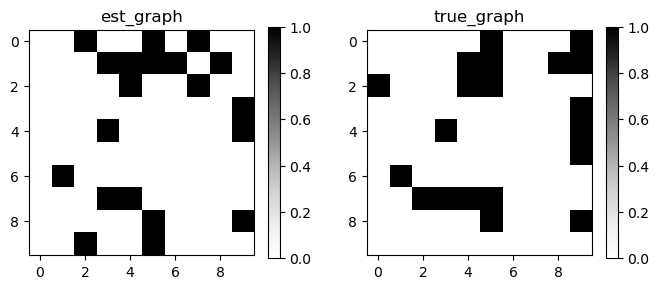

{'fdr': 0.3158, 'tpr': 0.65, 'fpr': 0.24, 'shd': 10, 'nnz': 19, 'precision': 0.65, 'recall': 0.65, 'F1': 0.65, 'gscore': 0.3}


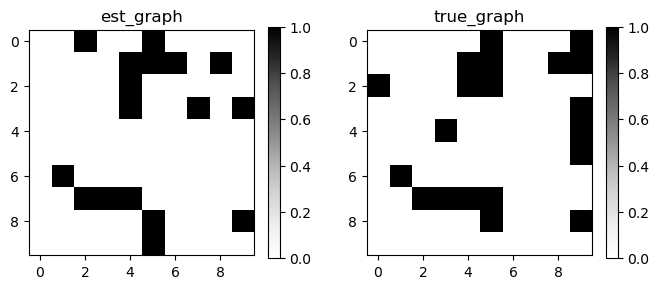

{'fdr': 0.2, 'tpr': 0.6, 'fpr': 0.12, 'shd': 8, 'nnz': 15, 'precision': 0.7059, 'recall': 0.6, 'F1': 0.6486, 'gscore': 0.35}


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import load_dataset

X, true_dag, _ = load_dataset(name='IID_Test')
pc = PC(variant='stable')
pc.learn(X)
GraphDAG(pc.causal_matrix, true_dag, save_name='result_pc')
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

pc = PC(variant='parallel')
pc.learn(X, p_cores=2)
GraphDAG(pc.causal_matrix, true_dag, save_name='result_pc')
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

In [ ]:
from castle.algorithms.pc.pc import find_skeleton
from castle.datasets import load_dataset

# true_dag, X = load_dataset(name='iid_test')
X,true_dag, _ = load_dataset('IID_Test')
skeleton, sep_set = find_skeleton(X, 0.05, 'fisherz')
print(skeleton)


2023-04-03 15:03:08,273 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


[[0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 0.]]


# ANMNonlinear

In [ ]:
# %load _anm.py
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
from sklearn.preprocessing import scale
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test


class GPR(object):
    """Estimator based on Gaussian Process Regressor

    Parameters
    ----------
    alpha : float or ndarray of shape (n_samples,), default=1e-10
        Value added to the diagonal of the kernel matrix during fitting.
        This can prevent a potential numerical issue during fitting, by
        ensuring that the calculated values form a positive definite matrix.
        It can also be interpreted as the variance of additional Gaussian
        measurement noise on the training observations. Note that this is
        different from using a `WhiteKernel`. If an array is passed, it must
        have the same number of entries as the data used for fitting and is
        used as datapoint-dependent noise level. Allowing to specify the
        noise level directly as a parameter is mainly for convenience and
        for consistency with Ridge.

    kernel : kernel instance, default=None
        The kernel specifying the covariance function of the GP. If None is
        passed, the kernel ``ConstantKernel(1.0, constant_value_bounds="fixed"
        * RBF(1.0, length_scale_bounds="fixed")`` is used as default. Note that
        the kernel hyperparameters are optimized during fitting unless the
        bounds are marked as "fixed".

    optimizer : "fmin_l_bfgs_b" or callable, default="fmin_l_bfgs_b"
        Can either be one of the internally supported optimizers for optimizing
        the kernel's parameters, specified by a string, or an externally
        defined optimizer passed as a callable. If a callable is passed, it
        must have the signature::

            def optimizer(obj_func, initial_theta, bounds):
                # * 'obj_func' is the objective function to be minimized, which
                #   takes the hyperparameters theta as parameter and an
                #   optional flag eval_gradient, which determines if the
                #   gradient is returned additionally to the function value
                # * 'initial_theta': the initial value for theta, which can be
                #   used by local optimizers
                # * 'bounds': the bounds on the values of theta
                ....
                # Returned are the best found hyperparameters theta and
                # the corresponding value of the target function.
                return theta_opt, func_min

        Per default, the 'L-BGFS-B' algorithm from scipy.optimize.minimize
        is used. If None is passed, the kernel's parameters are kept fixed.
        Available internal optimizers are::

            'fmin_l_bfgs_b'

    n_restarts_optimizer : int, default=0
        The number of restarts of the optimizer for finding the kernel's
        parameters which maximize the log-marginal likelihood. The first run
        of the optimizer is performed from the kernel's initial parameters,
        the remaining ones (if any) from thetas sampled log-uniform randomly
        from the space of allowed theta-values. If greater than 0, all bounds
        must be finite. Note that n_restarts_optimizer == 0 implies that one
        run is performed.

    normalize_y : bool, default=False
        Whether the target values y are normalized, the mean and variance of
        the target values are set equal to 0 and 1 respectively. This is
        recommended for cases where zero-mean, unit-variance priors are used.
        Note that, in this implementation, the normalisation is reversed
        before the GP predictions are reported.

    copy_X_train : bool, default=True
        If True, a persistent copy of the training data is stored in the
        object. Otherwise, just a reference to the training data is stored,
        which might cause predictions to change if the data is modified
        externally.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation used to initialize the centers.
        Pass an int for reproducible results across multiple function calls.
        See :term: `Glossary <random_state>`.

    See Also
    --------
    from sklearn.gaussian_process import GaussianProcessRegressor

    Examples
    --------
    >>> import numpy as np
    >>> x = np.random.rand(10).reshape((-1, 1))
    >>> y = np.random.rand(10).reshape((-1, 1))
    >>> gpr = GPR(alpha=1e-10)
    >>> y_pred = gpr.estimate(x, y)
    >>> print(y_pred)
    [[0.30898833]
     [0.51335394]
     [0.378371  ]
     [0.47051942]
     [0.51290679]
     [0.29678631]
     [0.77848816]
     [0.47589755]
     [0.21743226]
     [0.35258412]]
    """

    def __init__(self, **kwargs):
        super(GPR, self).__init__()
        self.regressor = GaussianProcessRegressor(**kwargs)

    def estimate(self, x, y):
        """Fit Gaussian process regression model and predict x.

        Parameters
        ----------
        x : array
            Variable seen as cause
        y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of x
        """

        self.regressor.fit(x, y)
        y_predict = self.regressor.predict(x)

        return y_predict


class ANMNonlinear(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use GPML with Gaussian kernel and independent Gaussian noise,
    optimizing the hyper-parameters for each regression individually.
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> from castle.datasets import DAG, IIDSimulation
    >>> from castle.algorithms.anm import ANMNonlinear

    >>> weighted_random_dag = DAG.erdos_renyi(n_nodes=6, n_edges=10,
    >>>                                      weight_range=(0.5, 2.0), seed=1)
    >>> dataset = IIDSimulation(W=weighted_random_dag, n=1000,
    >>>                         method='nonlinear', sem_type='gp-add')
    >>> true_dag, X = dataset.B, dataset.X

    >>> anm = ANMNonlinear(alpha=0.05)
    >>> anm.learn(data=X)

    >>> # plot predict_dag and true_dag
    >>> GraphDAG(anm.causal_matrix, true_dag, show=False, save_name='result')

    you can also provide more parameters to use it. like the flowing:
    >>> from sklearn.gaussian_process.kernels import Matern, RBF
    >>> kernel = Matern(nu=1.5)
    >>> # kernel = 1.0 * RBF(1.0)
    >>> anm = ANMNonlinear(alpha=0.05)
    >>> anm.learn(data=X, regressor=GPR(kernel=kernel))
    >>> # plot predict_dag and true_dag
    >>> GraphDAG(anm.causal_matrix, true_dag, show=False, save_name='result')
    """

    def __init__(self, alpha=0.05):
        super(ANMNonlinear, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=GPR(), test_method=hsic_test, **kwargs):
        """Set up and run the ANM_Nonlinear algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is GPR.
            If user defined, must implement `estimate` method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[1]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)),
                                    index=data.columns,
                                    columns=data.columns)

        for i, j in combinations(range(node_num), 2):
            x = data[:, i].reshape((-1, 1))
            y = data[:, j].reshape((-1, 1))

            flag = test_method(x, y, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.anm_estimate(x, y, regressor=regressor,
                                     test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.anm_estimate(y, x, regressor=regressor,
                                     test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def anm_estimate(self, x, y, regressor=GPR(), test_method=hsic_test):
        """Compute the fitness score of the ANM model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is GPR.
            If user defined, must implement `estimate` method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`

        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        Examples
        --------
        >>> import numpy as np
        >>> from castle.algorithms.anm import ANMNonlinear
        >>> np.random.seed(1)
        >>> x = np.random.rand(500, 2)
        >>> anm = ANMNonlinear(alpha=0.05)
        >>> print(anm.anm_estimate(x[:, [0]], x[:, [1]]))
        1
        """

        x = scale(x).reshape((-1, 1))
        y = scale(y).reshape((-1, 1))

        y_predict = regressor.estimate(x, y)
        flag = test_method(y - y_predict, x, alpha=self.alpha)

        return flag


# ANMNonlinear_Test

In [ ]:
import numpy as np
x = np.random.rand(10).reshape((-1, 1))
y = np.random.rand(10).reshape((-1, 1))
gpr = GPR(alpha=1e-10)
y_pred = gpr.estimate(x, y)
print(y_pred)

[[0.523]
 [0.081]
 [0.64 ]
 [0.355]
 [0.571]
 [0.687]
 [0.53 ]
 [0.702]
 [0.352]
 [0.742]]


2023-03-31 18:43:47,647 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


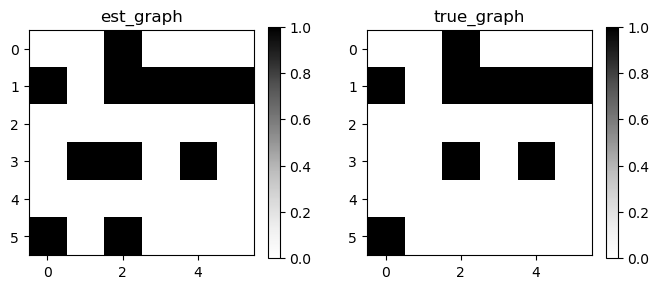

{'fdr': 0.1, 'tpr': 1.0, 'fpr': 0.1667, 'shd': 1, 'nnz': 10, 'precision': 0.8182, 'recall': 1.0, 'F1': 0.9, 'gscore': 0.7778}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

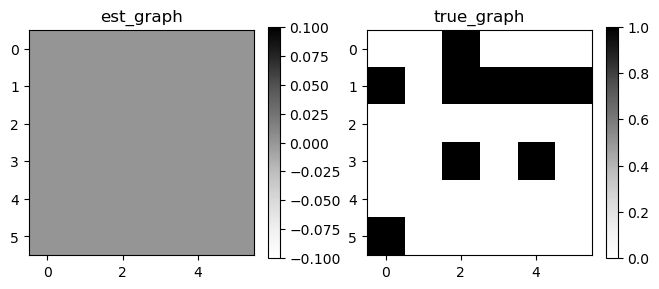

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 9, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


C:\Users\notebook\castle\metrics\evaluation.py:224: RuntimeWarning: invalid value encountered in true_divide
  precision = TP/TP_FP


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms.anm import ANMNonlinear

weighted_random_dag = DAG.erdos_renyi(n_nodes=6, n_edges=10,
                                     weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=1000,
                        method='nonlinear', sem_type='gp-add')
true_dag, X = dataset.B, dataset.X

anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag, save_name='result_anm')
# from castle.datasets import load_dataset
# X, true_dag, _ = load_dataset(name='IID_Test')
met = MetricsDAG(anm.causal_matrix, true_dag)
print(met.metrics)

from sklearn.gaussian_process.kernels import Matern, RBF
kernel = Matern(nu=1.5)
# kernel = 1.0 * RBF(1.0)
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X, regressor=GPR(kernel=kernel))
# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag, save_name='result_anm')
met = MetricsDAG(anm.causal_matrix, true_dag)
print(met.metrics)

In [ ]:
import numpy as np
from castle.algorithms.anm import ANMNonlinear
np.random.seed(1)
x = np.random.rand(500, 2)
anm = ANMNonlinear(alpha=0.05)
print(anm.anm_estimate(x[:, [0]], x[:, [1]]))

1


# DirectLiNGAM

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
from sklearn.utils import check_array
from sklearn.preprocessing import scale
from castle.algorithms.lingam.utils.base import _BaseLiNGAM
from castle.common import BaseLearner, Tensor
from castle.common.consts import DIRECT_LINGAM_VALID_PARAMS
from castle.common.validator import check_args_value


class DirectLiNGAM(_BaseLiNGAM, BaseLearner):
    """
    DirectLiNGAM Algorithm.
    A direct learning algorithm for linear non-Gaussian acyclic model (LiNGAM).
    Implementation of DirectLiNGAM Algorithm [1]_ [2]_, Construct a DirectLiNGAM model.

    Parameters
    ----------
    prior_knowledge : array-like, shape (n_features, n_features), optional (default=None)
        Prior knowledge used for causal discovery, where ``n_features`` is the number of features.

        The elements of prior knowledge matrix are defined as follows [1]_:

        * ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
        * ``1`` : :math:`x_i` has a directed path to :math:`x_j`
        * ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.
    measure : {'pwling', 'kernel'}, default='pwling'
        Measure to evaluate independence: 'pwling' [2]_ or 'kernel' [1]_.
    thresh : float,  default='0.3'
        Drop edge if |weight| < threshold

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix.
    weight_causal_matrix: numpy.ndarray
        Learned weighted causal structure matrix.

    References
    ----------
    .. [1] S. Shimizu, T. Inazumi, Y. Sogawa, A. Hyvärinen, Y. Kawahara, T. Washio, P. O. Hoyer and K. Bollen.
       DirectLiNGAM: A direct method for learning a linear non-Gaussian structural equation model.
       Journal of Machine Learning Research, 12(Apr): 1225--1248, 2011.
    .. [2] A. Hyvärinen and S. M. Smith. Pairwise likelihood ratios for estimation of non-Gaussian structural eauation models.
       Journal of Machine Learning Research 14:111-152, 2013.

    Examples
    --------
    >>> from castle.algorithms import DirectLiNGAM
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset(name='IID_Test')
    >>> n = DirectLiNGAM()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(DIRECT_LINGAM_VALID_PARAMS)
    def __init__(self, prior_knowledge=None, measure='pwling', thresh=0.3):

        super().__init__()

        self._prior_knowledge = prior_knowledge
        self._measure = measure
        self._thresh = thresh

    def learn(self, data, columns=None, **kwargs):
        """
        Set up and run the DirectLiNGAM algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        """

        X = Tensor(data, columns=columns)

        self.fit(X)

        weight_causal_matrix = self.adjacency_matrix_.T
        self.weight_causal_matrix = Tensor(weight_causal_matrix,
                                           index=X.columns,
                                           columns=X.columns)

        causal_matrix = (abs(self.adjacency_matrix_) > self._thresh).astype(int).T
        self.causal_matrix = Tensor(causal_matrix,
                                    index=X.columns,
                                    columns=X.columns)

    def fit(self, X):
        """
        Fit the model to X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        # Check parameters
        X = check_array(X)
        n_features = X.shape[1]

        if self._prior_knowledge is not None:
            self._Aknw = check_array(self._prior_knowledge)
            self._Aknw = np.where(self._Aknw < 0, np.nan, self._Aknw)
            if (n_features, n_features) != self._Aknw.shape:
                raise ValueError(
                    'The shape of prior knowledge must be (n_features, n_features)')
        else:
            self._Aknw = None

        # Causal discovery
        U = np.arange(n_features)
        K = []
        X_ = np.copy(X)
        if self._measure == 'kernel':
            X_ = scale(X_)

        for _ in range(n_features):
            if self._measure == 'kernel':
                m = self._search_causal_order_kernel(X_, U)
            else:
                m = self._search_causal_order(X_, U)
            for i in U:
                if i != m:
                    X_[:, i] = self._residual(X_[:, i], X_[:, m])
            K.append(m)
            U = U[U != m]

        self._causal_order = K
        return self._estimate_adjacency_matrix(X)

    def _residual(self, xi, xj):
        """The residual when xi is regressed on xj."""
        return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj

    def _entropy(self, u):
        """Calculate entropy using the maximum entropy approximations."""
        k1 = 79.047
        k2 = 7.4129
        gamma = 0.37457
        return (1 + np.log(2 * np.pi)) / 2 - \
            k1 * (np.mean(np.log(np.cosh(u))) - gamma)**2 - \
            k2 * (np.mean(u * np.exp((-u**2) / 2)))**2

    def _diff_mutual_info(self, xi_std, xj_std, ri_j, rj_i):
        """Calculate the difference of the mutual informations."""
        return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - \
               (self._entropy(xi_std) + self._entropy(rj_i / np.std(rj_i)))

    def _search_candidate(self, U):
        """ Search for candidate features """
        # If no prior knowledge is specified, nothing to do.
        if self._Aknw is None:
            return U, []

        # Find exogenous features
        Uc = []
        for j in U:
            index = U[U != j]
            if self._Aknw[j][index].sum() == 0:
                Uc.append(j)

        # Find endogenous features, and then find candidate features
        if len(Uc) == 0:
            U_end = []
            for j in U:
                index = U[U != j]
                if np.nansum(self._Aknw[j][index]) > 0:
                    U_end.append(j)

            # Find sink features (original)
            for i in U:
                index = U[U != i]
                if self._Aknw[index, i].sum() == 0:
                    U_end.append(i)
            Uc = [i for i in U if i not in set(U_end)]

        # make V^(j)
        Vj = []
        for i in U:
            if i in Uc:
                continue
            if self._Aknw[i][Uc].sum() == 0:
                Vj.append(i)
        return Uc, Vj

    def _search_causal_order(self, X, U):
        """Search the causal ordering."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        M_list = []
        for i in Uc:
            M = 0
            for j in U:
                if i != j:
                    xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
                    xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
                    ri_j = xi_std if i in Vj and j in Uc else self._residual(xi_std, xj_std)
                    rj_i = xj_std if j in Vj and i in Uc else self._residual(xj_std, xi_std)
                    M += np.min([0, self._diff_mutual_info(xi_std, xj_std, ri_j, rj_i)])**2
            M_list.append(-1.0 * M)
        return Uc[np.argmax(M_list)]

    def _mutual_information(self, x1, x2, param):
        """Calculate the mutual informations."""
        kappa, sigma = param
        n = len(x1)
        X1 = np.tile(x1, (n, 1))
        K1 = np.exp(-1/(2*sigma**2) * (X1**2 + X1.T**2 - 2*X1*X1.T))
        X2 = np.tile(x2, (n, 1))
        K2 = np.exp(-1/(2*sigma**2) * (X2**2 + X2.T**2 - 2*X2*X2.T))

        tmp1 = K1 + n*kappa*np.identity(n)/2
        tmp2 = K2 + n*kappa*np.identity(n)/2
        K_kappa = np.r_[np.c_[tmp1 @ tmp1, K1 @ K2],
                        np.c_[K2 @ K1, tmp2 @ tmp2]]
        D_kappa = np.r_[np.c_[tmp1 @ tmp1, np.zeros([n, n])],
                        np.c_[np.zeros([n, n]), tmp2 @ tmp2]]

        sigma_K = np.linalg.svd(K_kappa, compute_uv=False)
        sigma_D = np.linalg.svd(D_kappa, compute_uv=False)

        return (-1/2)*(np.sum(np.log(sigma_K)) - np.sum(np.log(sigma_D)))

    def _search_causal_order_kernel(self, X, U):
        """Search the causal ordering by kernel method."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        if X.shape[0] > 1000:
            param = [2e-3, 0.5]
        else:
            param = [2e-2, 1.0]

        Tkernels = []
        for j in Uc:
            Tkernel = 0
            for i in U:
                if i != j:
                    ri_j = X[:, i] if j in Vj and i in Uc else self._residual(
                        X[:, i], X[:, j])
                    Tkernel += self._mutual_information(X[:, j], ri_j, param)
            Tkernels.append(Tkernel)

        return Uc[np.argmin(Tkernels)]


# DirectLiNGAM_Test

2023-03-31 18:55:13,687 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in v

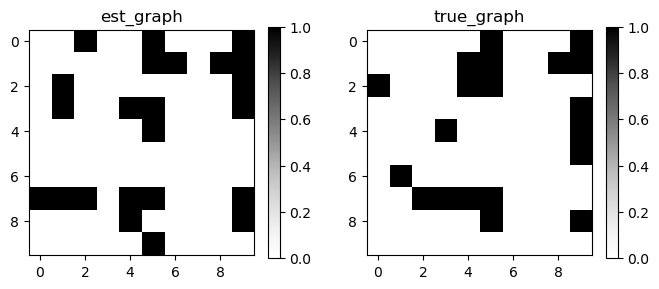

{'fdr': 0.5652, 'tpr': 0.5, 'fpr': 0.52, 'shd': 19, 'nnz': 23, 'precision': 0.4348, 'recall': 0.5, 'F1': 0.4651, 'gscore': 0.0}


In [ ]:
from castle.algorithms import DirectLiNGAM
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset(name='IID_Test')
n = DirectLiNGAM()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

# ICALiNGAM

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.utils import check_array
from sklearn.decomposition import FastICA

from castle.algorithms.lingam.utils.base import _BaseLiNGAM
from castle.common import BaseLearner, Tensor


class ICALiNGAM(_BaseLiNGAM, BaseLearner):
    """
    ICALiNGAM Algorithm.
    An ICA-based learning algorithm for linear non-Gaussian acyclic model (LiNGAM).
    Implementation of ICA-based LiNGAM Algorithm [1]_, Construct a ICA-based LiNGAM model.

    Parameters
    ----------
    random_state : int, optional (default=None)
        ``random_state`` is the seed used by the random number generator.
    max_iter : int, optional (default=1000)
        The maximum number of iterations of FastICA.
    thresh : float,  default='0.3'
        Drop edge if |weight| < threshold

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix
    weight_causal_matrix: numpy.ndarray
        Learned weighted causal structure matrix.

    References
    ----------
    .. [1] S. Shimizu, P. O. Hoyer, A. Hyvärinen, and A. J. Kerminen.
       A linear non-gaussian acyclic model for causal discovery.
       Journal of Machine Learning Research, 7:2003-2030, 2006.

    Examples
    --------
    >>> from castle.algorithms import ICALiNGAM
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset(name='IID_Test')
    >>> n = ICALiNGAM()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, random_state=None, max_iter=1000, thresh=0.3):

        super().__init__()

        self._random_state = random_state
        self._max_iter = max_iter
        self._thresh = thresh

    def learn(self, data, columns=None):
        """
        Set up and run the ICALiNGAM algorithm.

        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        """
        X = Tensor(data, columns=columns)

        self.fit(X)

        weight_causal_matrix = self.adjacency_matrix_.T
        self.weight_causal_matrix = Tensor(weight_causal_matrix,
                                           index=X.columns, columns=X.columns)

        causal_matrix = (abs(self.adjacency_matrix_) > self._thresh).astype(int).T
        self.causal_matrix = Tensor(causal_matrix,
                                    index=X.columns, columns=X.columns)

    def fit(self, X):
        """
        Fit the model to X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        Returns
        -------
        self : object
            Returns the instance of self.
        """
        X = check_array(X)

        # obtain a unmixing matrix from the given data
        ica = FastICA(max_iter=self._max_iter, random_state=self._random_state)
        ica.fit(X)
        W_ica = ica.components_

        # obtain a permuted W_ica
        _, col_index = linear_sum_assignment(1 / np.abs(W_ica))
        PW_ica = np.zeros_like(W_ica)
        PW_ica[col_index] = W_ica

        # obtain a vector to scale
        D = np.diag(PW_ica)[:, np.newaxis]

        # estimate an adjacency matrix
        W_estimate = PW_ica / D
        B_estimate = np.eye(len(W_estimate)) - W_estimate

        causal_order = self._estimate_causal_order(B_estimate)
        self._causal_order = causal_order

        return self._estimate_adjacency_matrix(X)

    def _search_causal_order(self, matrix):
        """
        Obtain a causal order from the given matrix strictly.

        Parameters
        ----------
        matrix : array-like, shape (n_features, n_samples)
            Target matrix.

        Return
        ------
        causal_order : array, shape [n_features, ]
            A causal order of the given matrix on success, None otherwise.
        """
        causal_order = []

        row_num = matrix.shape[0]
        original_index = np.arange(row_num)

        while 0 < len(matrix):
            # find a row all of which elements are zero
            row_index_list = np.where(np.sum(np.abs(matrix), axis=1) == 0)[0]
            if len(row_index_list) == 0:
                break

            target_index = row_index_list[0]

            # append i to the end of the list
            causal_order.append(original_index[target_index])
            original_index = np.delete(original_index, target_index, axis=0)

            # remove the i-th row and the i-th column from matrix
            mask = np.delete(np.arange(len(matrix)), target_index, axis=0)
            matrix = matrix[mask][:, mask]

        if len(causal_order) != row_num:
            causal_order = None

        return causal_order

    def _estimate_causal_order(self, matrix):
        """
        Obtain a lower triangular from the given matrix approximately.

        Parameters
        ----------
        matrix : array-like, shape (n_features, n_samples)
            Target matrix.

        Return
        ------
        causal_order : array, shape [n_features, ]
            A causal order of the given matrix on success, None otherwise.
        """
        causal_order = None

        # set the m(m + 1)/2 smallest(in absolute value) elements of the matrix to zero
        pos_list = np.argsort(np.abs(matrix), axis=None)
        pos_list = np.vstack(np.unravel_index(pos_list, matrix.shape)).T
        initial_zero_num = int(matrix.shape[0] * (matrix.shape[0] + 1) / 2)
        for i, j in pos_list[:initial_zero_num]:
            matrix[i, j] = 0

        for i, j in pos_list[initial_zero_num:]:
            # set the smallest(in absolute value) element to zero
            matrix[i, j] = 0

            causal_order = self._search_causal_order(matrix)
            if causal_order is not None:
                break

        return causal_order


# ICALiNGAM_Test

2023-03-31 18:56:27,057 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set paramete

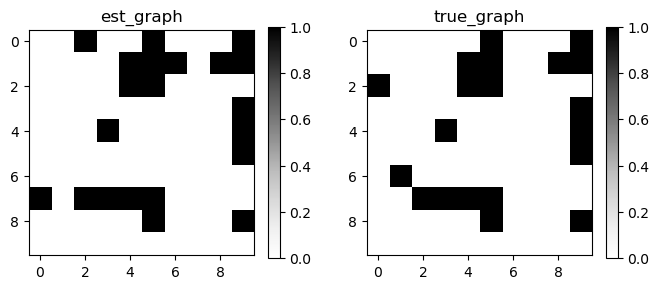

{'fdr': 0.1429, 'tpr': 0.9, 'fpr': 0.12, 'shd': 3, 'nnz': 21, 'precision': 0.8571, 'recall': 0.9, 'F1': 0.878, 'gscore': 0.75}


In [ ]:
from castle.algorithms import ICALiNGAM
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset(name='IID_Test')
n = ICALiNGAM()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

# GES

In [ ]:
import numpy as np
from castle.common import BaseLearner, Tensor
from castle.algorithms.ges.operators import search
from castle.algorithms.ges.score.local_scores import (BICScore, BDeuScore, DecomposableScore)


class GES(BaseLearner):
    """
    Greedy equivalence search for causal discovering

    References
    ----------
    [1]: https://www.sciencedirect.com/science/article/pii/S0888613X12001636
    [2]: https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf

    Parameters
    ----------
    criterion: str for DecomposableScore object
        scoring criterion, one of ['bic', 'bdeu'].

        Notes:
            1. 'bdeu' just for discrete variable.
            2. if you want to customize criterion, you must create a class
            and inherit the base class `DecomposableScore` in module
            `ges.score.local_scores`
    method: str
        effective when `criterion='bic'`, one of ['r2', 'scatter'].
    k: float, default: 0.001
        structure prior, effective when `criterion='bdeu'`.
    N: int, default: 10
        prior equivalent sample size, effective when `criterion='bdeu'`
    Examples
    --------
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> from castle.datasets import load_dataset

    >>> X, true_dag, _ = load_dataset(name='IID_Test')
    >>> algo = GES()
    >>> algo.learn(X)
    >>> GraphDAG(algo.causal_matrix, true_dag, save_name='result_pc')
    >>> met = MetricsDAG(algo.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, criterion='bic', method='scatter', k=0.001, N=10):
        super(GES, self).__init__()
        if isinstance(criterion, str):
            if criterion not in ['bic', 'bdeu']:
                raise ValueError(f"if criterion is str, it must be one of "
                                 f"['bic', 'bdeu'], but got {criterion}.")
        else:
            if not isinstance(criterion, DecomposableScore):
                raise TypeError(f"The criterion is not instance of "
                                f"DecomposableScore.")
        self.criterion = criterion
        self.method = method
        self.k = k
        self.N = N

    def learn(self, data, columns=None, **kwargs):

        d = data.shape[1]
        e = np.zeros((d, d), dtype=int)

        if self.criterion == 'bic':
            self.criterion = BICScore(data=data,
                                      method=self.method)
        elif self.criterion == 'bdeu':
            self.criterion = BDeuScore(data=data, k=self.k, N=self.N)

        c = search.fes(C=e, criterion=self.criterion)
        c = search.bes(C=c, criterion=self.criterion)

        self._causal_matrix = Tensor(c, index=columns, columns=columns)


# GES_Test

2023-03-31 19:01:55,766 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


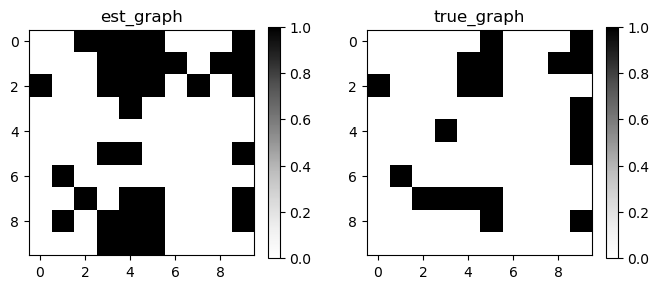

{'fdr': 0.4483, 'tpr': 0.8, 'fpr': 0.52, 'shd': 14, 'nnz': 29, 'precision': 0.4706, 'recall': 0.8, 'F1': 0.5926, 'gscore': 0.0}


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import load_dataset

X, true_dag, _ = load_dataset(name='IID_Test')
algo = GES()
algo.learn(X)
GraphDAG(algo.causal_matrix, true_dag, save_name='result_pc')
met = MetricsDAG(algo.causal_matrix, true_dag)
print(met.metrics)

# PNL

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import itertools
import logging
import torch
import torch.nn as nn
import numpy as np

from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test

from castle.algorithms.gradient.pnl.torch.utils import batch_loader, compute_jacobian, compute_entropy


class MLP(nn.Module):
    """
    Multi-layer perceptron

    """

    def __init__(self, input_dim, hidden_layers, hidden_units, output_dim,
                 bias=True, activation=None, device=None) -> None:
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.output_dim = output_dim
        self.bias = bias
        self.activation = activation
        self.device = device

        mlp = []
        for i in range(self.hidden_layers):
            input_size = self.hidden_units
            if i == 0:
                input_size = self.input_dim
            weight = nn.Linear(in_features=input_size,
                               out_features=self.hidden_units,
                               bias=self.bias,
                               device=self.device)
            mlp.append(weight)
            if self.activation is not None:
                mlp.append(self.activation)
        out_layer = nn.Linear(in_features=self.hidden_units,
                              out_features=self.output_dim,
                              bias=self.bias,
                              device=self.device)
        mlp.append(out_layer)

        self.mlp = nn.Sequential(*mlp)

    def forward(self, x) -> torch.Tensor:

        out = self.mlp(x)

        return out


class PNL(BaseLearner):
    """
    On the Identifiability of the Post-Nonlinear Causal Model

    References
    ----------
    https://arxiv.org/ftp/arxiv/papers/1205/1205.2599.pdf

    Parameters
    ----------
    hidden_layers: int
        number of hidden layer of mlp
    hidden_units: int
        number of unit of per hidden layer
    batch_size: int
        size of training batch
    epochs: int
        training times on all samples
    lr: float
        learning rate
    alpha: float
        significance level
    bias: bool
        whether use bias
    activation: callable
        nonlinear activation function
    device_type: str
        'cpu' or 'gpu', default: 'cpu'
    device_ids: int or str
        e.g. 0 or '0,1', denotes which gpu that you want to use.

    Examples
    --------
    >>> from castle.algorithms.gradient.pnl.torch import PNL
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> n = PNL()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, hidden_layers=1, hidden_units=10, batch_size=64,
                 epochs=100, lr=1e-4, alpha=0.01, bias=True,
                 activation=nn.LeakyReLU(), device_type='cpu', device_ids=None):
        super(PNL, self).__init__()
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.alpha = alpha
        self.bias = bias
        self.activation = activation
        self.device_type = device_type
        self.device_ids = device_ids
        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type='cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, **kwargs):

        n_nodes = data.shape[1]
        g = np.zeros((n_nodes, n_nodes))

        all_nodes_pair = itertools.permutations(range(n_nodes), 2)
        for i, j in all_nodes_pair:
            x1 = torch.tensor(data[:, i], device=self.device).unsqueeze(-1)
            x2 = torch.tensor(data[:, j], device=self.device).unsqueeze(-1)

            # initialize model and parameters
            l1 = MLP(input_dim=1, hidden_layers=self.hidden_layers,hidden_units=self.hidden_units, output_dim=1,bias=self.bias, activation=self.activation,device=self.device)
            l2 = MLP(input_dim=1, hidden_layers=self.hidden_layers,
                     hidden_units=self.hidden_units, output_dim=1,
                     bias=self.bias, activation=self.activation,
                     device=self.device)
            optimizer = torch.optim.SGD([{'params': l1.parameters()},
                                         {'params': l2.parameters()}],
                                        lr=self.lr)
            # nonlinear ICA
            e2 = self._nonlinear_ica(l1, l2, x1, x2, optimizer=optimizer)

            # kernel-based independent test
            ind = hsic_test(x1.cpu().detach().numpy(),
                            e2.cpu().detach().numpy(), alpha=self.alpha)
            if ind == 0:  # x1->x2
                g[i, j] = 1

        self.causal_matrix = Tensor(g, index=columns, columns=columns)

    def _nonlinear_ica(self, f1, f2, x1, x2, optimizer):

        batch_generator = batch_loader(x1, x2, batch_size=self.batch_size)
        for i in range(self.epochs):
            for x1_batch, x2_batch in batch_generator:
                optimizer.zero_grad()

                l2_jacob = torch.diag(compute_jacobian(f2, x2_batch).squeeze())
                e2 = f2(x2_batch) - f1(x1_batch)
                entropy = compute_entropy(e2)
                loss = entropy - torch.log(torch.abs(l2_jacob)).sum()

                loss.backward()
                optimizer.step()

        e2 = f2(x2) - f1(x1)

        return e2


# PNL_Test

In [ ]:
from castle.algorithms.gradient.pnl.torch import PNL
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
n = PNL()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-04 09:51:08,979 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-04 09:51:08,981 - C:\Users\notebook\castle\algorithms\gradient\pnl\torch\pnl.py[line:135] - INFO: GPU is unavailable.


TypeError: __init__() got an unexpected keyword argument 'device'

In [ ]:
  def __init__(self, input_dim, hidden_layers, hidden_units, output_dim,
                 bias=True, activation=None, device=None) -> None:
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.output_dim = output_dim
        self.bias = bias
        self.activation = activation
        self.device = device

        mlp = []
        for i in range(self.hidden_layers):
            input_size = self.hidden_units
            if i == 0:
                input_size = self.input_dim
            weight = nn.Linear(in_features=input_size,
                               out_features=self.hidden_units,
                               bias=self.bias,
                               device=self.device)
            mlp.append(weight)
            if self.activation is not None:
                mlp.append(self.activation)
        out_layer = nn.Linear(in_features=self.hidden_units,
                              out_features=self.output_dim,
                              bias=self.bias,
                              device=self.device)
        mlp.append(out_layer)

        self.mlp = nn.Sequential(*mlp)

# NOTEARS_Linear

In [ ]:
# coding=utf-8
# 2021.03 modified (1) notears_linear(def) to Notears(class)
# 2021.03 added    (1) logging;
#                  (2) BaseLearner
# 2021.03 deleted  (1) __main__
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Xun Zheng (https://github.com/xunzheng/notears)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import numpy as np
import scipy.optimize as sopt
from scipy.special import expit as sigmoid

from castle.common import BaseLearner, Tensor
from castle.common.consts import NOTEARS_VALID_PARAMS
from castle.common.validator import check_args_value


class Notears(BaseLearner):
    """
    Notears Algorithm.
    A gradient-based algorithm for linear data models (typically with least-squares loss).

    Parameters
    ----------
    lambda1: float
        l1 penalty parameter
    loss_type: str
        l2, logistic, poisson
    max_iter: int
        max num of dual ascent steps
    h_tol: float
        exit if |h(w_est)| <= htol
    rho_max: float
        exit if rho >= rho_max
    w_threshold: float
        drop edge if |weight| < threshold

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/1803.01422

    Examples
    --------
    >>> from castle.algorithms import Notears
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> n = Notears()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(NOTEARS_VALID_PARAMS)
    def __init__(self, lambda1=0.1,
                 loss_type='l2',
                 max_iter=100,
                 h_tol=1e-8,
                 rho_max=1e+16,
                 w_threshold=0.3):

        super().__init__()

        self.lambda1 = lambda1
        self.loss_type = loss_type
        self.max_iter = max_iter
        self.h_tol = h_tol
        self.rho_max = rho_max
        self.w_threshold = w_threshold

    def learn(self, data, columns=None, **kwargs):
        """
        Set up and run the Notears algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        """
        X = Tensor(data, columns=columns)

        W_est = self.notears_linear(X, lambda1=self.lambda1,
                                    loss_type=self.loss_type,
                                    max_iter=self.max_iter,
                                    h_tol=self.h_tol,
                                    rho_max=self.rho_max)
        causal_matrix = (abs(W_est) > self.w_threshold).astype(int)
        self.weight_causal_matrix = Tensor(W_est,
                                           index=X.columns,
                                           columns=X.columns)
        self.causal_matrix = Tensor(causal_matrix, index=X.columns,
                                    columns=X.columns)

    def notears_linear(self, X, lambda1, loss_type, max_iter, h_tol,
                       rho_max):
        """
        Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using
        augmented Lagrangian.

        Parameters
        ----------
        X: np.ndarray
            n*d sample matrix

        Return
        ------
        W_est: np.ndarray
            d*d estimated DAG
        """
        def _loss(W):
            """Evaluate value and gradient of loss."""
            M = X @ W
            if loss_type == 'l2':
                R = X - M
                loss = 0.5 / X.shape[0] * (R ** 2).sum()
                G_loss = - 1.0 / X.shape[0] * X.T @ R
            elif loss_type == 'logistic':
                loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
                G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
            elif loss_type == 'poisson':
                S = np.exp(M)
                loss = 1.0 / X.shape[0] * (S - X * M).sum()
                G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
            else:
                raise ValueError('unknown loss type')
            return loss, G_loss

        def _h(W):
            """
            Evaluate value and gradient of acyclicity constraint.
            """
            #     E = slin.expm(W * W)  # (Zheng et al. 2018)
            #     h = np.trace(E) - d
            M = np.eye(d) + W * W / d  # (Yu et al. 2019)
            E = np.linalg.matrix_power(M, d - 1)
            h = (E.T * M).sum() - d
            G_h = E.T * W * 2
            return h, G_h

        def _adj(w):
            """
            Convert doubled variables ([2 d^2] array) back to original
            variables ([d, d] matrix).
            """
            return (w[:d * d] - w[d * d:]).reshape([d, d])

        def _func(w):
            """
            Evaluate value and gradient of augmented Lagrangian for
            doubled variables ([2 d^2] array).
            """
            W = _adj(w)
            loss, G_loss = _loss(W)
            h, G_h = _h(W)
            obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
            G_smooth = G_loss + (rho * h + alpha) * G_h
            g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1),
                                   axis=None)
            return obj, g_obj

        n, d = X.shape
        # double w_est into (w_pos, w_neg)
        w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf
        bnds = [(0, 0) if i == j else (0, None) for _ in range(2)
                for i in range(d) for j in range(d)]
        if loss_type == 'l2':
            X = X - np.mean(X, axis=0, keepdims=True)

        logging.info('[start]: n={}, d={}, iter_={}, h_={}, rho_={}'.format( \
                    n, d, max_iter, h_tol, rho_max))

        for i in range(max_iter):
            w_new, h_new = None, None
            while rho < rho_max:
                sol = sopt.minimize(_func, w_est, method='L-BFGS-B',
                                    jac=True, bounds=bnds)
                w_new = sol.x
                h_new, _ = _h(_adj(w_new))

                logging.info(
                    '[iter {}] h={:.3e}, loss={:.3f}, rho={:.1e}'.format( \
                    i, h_new, _func(w_est)[0], rho))

                if h_new > 0.25 * h:
                    rho *= 10
                else:
                    break
            w_est, h = w_new, h_new
            alpha += rho * h

            if h <= h_tol or rho >= rho_max:
                break

        W_est = _adj(w_est)

        logging.info('FINISHED')

        return W_est


# NOTEARS_Linear_Test

2023-03-31 19:08:15,152 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-03-31 19:08:15,154 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:195] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16
2023-03-31 19:08:15,238 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 0] h=7.021e-01, loss=171.611, rho=1.0e+00
2023-03-31 19:08:15,451 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=4.557e-01, loss=4.686, rho=1.0e+00
2023-03-31 19:08:15,673 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=2.163e-01, loss=6.904, rho=1.0e+01
2023-03-31 19:08:15,939 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=7.563e-02, loss=29.087, rho=1.0e+02
2023-03-31 19:08:16,253 - C:\Users\notebook\castle\algorithms\gradient\notears\linear.py[line:206] - INFO

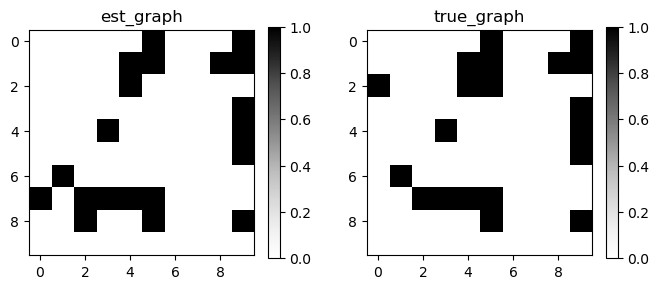

{'fdr': 0.1, 'tpr': 0.9, 'fpr': 0.08, 'shd': 4, 'nnz': 20, 'precision': 0.9, 'recall': 0.9, 'F1': 0.9, 'gscore': 0.8}


In [ ]:
from castle.algorithms import Notears
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
n = Notears()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

# NOTEARS_Nonlinear_MLP

In [ ]:
# coding=utf-8
# 2021.03 added    (1) logging;
#                  (2) BaseLearner;
#                  (3) NotearsMLP, NotearsSob;
# 2021.03 deleted  (1) __main__
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Xun Zheng (https://github.com/xunzheng/notears)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import math

import torch
import torch.nn as nn
import numpy as np
from castle.algorithms.gradient.notears.torch.utils.locally_connected import LocallyConnected

torch.set_default_dtype(torch.double)


class MLPModel(nn.Module):
    def __init__(self, dims, bias=True, device=None):
        """
        Multilayer perceptron.

        Parameters
        ----------
        dims: tuple
            Network shape parameters
        bias:
            Indicates whether to use weight deviation.
        device: option, default: None
            torch.device('cpu') or torch.device('cuda')
        """
        super(MLPModel, self).__init__()
        if len(dims) < 2:
            raise ValueError(f"The size of dims at least greater equal to 2, contains one "
                             f"one hidden layer and one output_layer")
        if dims[-1] != 1:
            raise ValueError(f"The dimension of output layer must be 1, but got {dims[-1]}.")
        d = dims[0]
        self.dims = dims
        self.device = device
        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias, device=self.device)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias, device=self.device)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers).to(device=self.device)


    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def forward(self, x):  # [n, d] -> [n, d]
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1]
        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]
        for fc in self.fc2:
            x = torch.sigmoid(x)  # [n, d, m1]
            x = fc(x)  # [n, d, m2]
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """
        Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG.

        Returns
        -------

        """
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        # h = trace_expm(A) - d  # (Zheng et al. 2018)
        init_e = torch.eye(d).to(self.device)
        M = init_e + A / d  # (Yu et al. 2019)
        E = torch.matrix_power(M, d - 1)
        h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """
        Take 2-norm-squared of all parameters.

        Returns
        -------

        """
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """
        Take l1 norm of fc1 weight.

        Returns
        -------

        """
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """
        Get W from fc1 weights, take 2-norm over m1 dim.

        Returns
        -------

        """
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


class SobolevModel(nn.Module):
    """
    Sobolev network.

    Parameters
    ----------
    d: int
        Num variables.
    k: int
        Num expansion of each variable.
    bias:
        Indicates whether to use weight deviation.
    device: option, default: None
        torch.device('cpu') or torch.device('cuda')
    """
    def __init__(self, d, k, bias=False, device=None):
        super(SobolevModel, self).__init__()
        self.d, self.k = d, k
        self.l2_reg_store = None
        self.device = device
        self.fc1_pos = nn.Linear(d * k, d, bias=bias, device=self.device)  # ik -> j
        self.fc1_neg = nn.Linear(d * k, d, bias=bias, device=self.device)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        nn.init.zeros_(self.fc1_pos.weight)
        nn.init.zeros_(self.fc1_neg.weight)

    def _bounds(self):
        # weight shape [j, ik]
        bounds = []
        for j in range(self.d):
            for i in range(self.d):
                for _ in range(self.k):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def sobolev_basis(self, x):  # [n, d] -> [n, dk]
        seq = []
        for kk in range(self.k):
            mu = 2.0 / (2 * kk + 1) / math.pi  # sobolev basis
            psi = mu * torch.sin(x / mu)
            seq.append(psi)  # [n, d] * k
        bases = torch.stack(seq, dim=2)  # [n, d, k]
        bases = bases.view(-1, self.d * self.k)  # [n, dk]
        return bases

    def forward(self, x):  # [n, d] -> [n, d]
        bases = self.sobolev_basis(x)  # [n, dk]
        x = self.fc1_pos(bases) - self.fc1_neg(bases)  # [n, d]
        self.l2_reg_store = torch.sum(x ** 2) / x.shape[0]
        return x

    def h_func(self):
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        # h = trace_expm(A) - d  # (Zheng et al. 2018)
        init_e = torch.eye(self.d).to(self.device)
        M = init_e + A / self.d  # (Yu et al. 2019)
        E = torch.matrix_power(M, self.d - 1)
        h = (E.t() * M).sum() - self.d
        return h

    def l2_reg(self):
        reg = self.l2_reg_store
        return reg

    def fc1_l1_reg(self):
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


def squared_loss(output, target):
    """
    Least squares loss function.

    Parameters
    ----------
    output: torch.tenser
        network output
    target: torch.tenser
        raw input
    Returns
    -------
    : torch.tenser
        loss value
    """
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss

# NOTEARS_Nonlinear_SOB

In [ ]:
# coding=utf-8
# 2021.03 added    (1) logging;
#                  (2) BaseLearner;
#                  (3) NotearsMLP, NotearsSob;
# 2021.03 deleted  (1) __main__
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Xun Zheng (https://github.com/xunzheng/notears)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import math

import torch
import torch.nn as nn
import numpy as np
from castle.algorithms.gradient.notears.torch.utils.locally_connected import LocallyConnected

torch.set_default_dtype(torch.double)


class MLPModel(nn.Module):
    def __init__(self, dims, bias=True, device=None):
        """
        Multilayer perceptron.

        Parameters
        ----------
        dims: tuple
            Network shape parameters
        bias:
            Indicates whether to use weight deviation.
        device: option, default: None
            torch.device('cpu') or torch.device('cuda')
        """
        super(MLPModel, self).__init__()
        if len(dims) < 2:
            raise ValueError(f"The size of dims at least greater equal to 2, contains one "
                             f"one hidden layer and one output_layer")
        if dims[-1] != 1:
            raise ValueError(f"The dimension of output layer must be 1, but got {dims[-1]}.")
        d = dims[0]
        self.dims = dims
        self.device = device
        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias, device=self.device)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias, device=self.device)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers).to(device=self.device)


    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def forward(self, x):  # [n, d] -> [n, d]
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1]
        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]
        for fc in self.fc2:
            x = torch.sigmoid(x)  # [n, d, m1]
            x = fc(x)  # [n, d, m2]
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """
        Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG.

        Returns
        -------

        """
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        # h = trace_expm(A) - d  # (Zheng et al. 2018)
        init_e = torch.eye(d).to(self.device)
        M = init_e + A / d  # (Yu et al. 2019)
        E = torch.matrix_power(M, d - 1)
        h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """
        Take 2-norm-squared of all parameters.

        Returns
        -------

        """
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """
        Take l1 norm of fc1 weight.

        Returns
        -------

        """
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """
        Get W from fc1 weights, take 2-norm over m1 dim.

        Returns
        -------

        """
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


class SobolevModel(nn.Module):
    """
    Sobolev network.

    Parameters
    ----------
    d: int
        Num variables.
    k: int
        Num expansion of each variable.
    bias:
        Indicates whether to use weight deviation.
    device: option, default: None
        torch.device('cpu') or torch.device('cuda')
    """
    def __init__(self, d, k, bias=False, device=None):
        super(SobolevModel, self).__init__()
        self.d, self.k = d, k
        self.l2_reg_store = None
        self.device = device
        self.fc1_pos = nn.Linear(d * k, d, bias=bias, device=self.device)  # ik -> j
        self.fc1_neg = nn.Linear(d * k, d, bias=bias, device=self.device)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        nn.init.zeros_(self.fc1_pos.weight)
        nn.init.zeros_(self.fc1_neg.weight)

    def _bounds(self):
        # weight shape [j, ik]
        bounds = []
        for j in range(self.d):
            for i in range(self.d):
                for _ in range(self.k):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def sobolev_basis(self, x):  # [n, d] -> [n, dk]
        seq = []
        for kk in range(self.k):
            mu = 2.0 / (2 * kk + 1) / math.pi  # sobolev basis
            psi = mu * torch.sin(x / mu)
            seq.append(psi)  # [n, d] * k
        bases = torch.stack(seq, dim=2)  # [n, d, k]
        bases = bases.view(-1, self.d * self.k)  # [n, dk]
        return bases

    def forward(self, x):  # [n, d] -> [n, d]
        bases = self.sobolev_basis(x)  # [n, dk]
        x = self.fc1_pos(bases) - self.fc1_neg(bases)  # [n, d]
        self.l2_reg_store = torch.sum(x ** 2) / x.shape[0]
        return x

    def h_func(self):
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        # h = trace_expm(A) - d  # (Zheng et al. 2018)
        init_e = torch.eye(self.d).to(self.device)
        M = init_e + A / self.d  # (Yu et al. 2019)
        E = torch.matrix_power(M, self.d - 1)
        h = (E.t() * M).sum() - self.d
        return h

    def l2_reg(self):
        reg = self.l2_reg_store
        return reg

    def fc1_l1_reg(self):
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


def squared_loss(output, target):
    """
    Least squares loss function.

    Parameters
    ----------
    output: torch.tenser
        network output
    target: torch.tenser
        raw input
    Returns
    -------
    : torch.tenser
        loss value
    """
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss

# NOTEARS_Nonlinear_MLP&SOB

In [ ]:
# coding=utf-8
# 2021.03 added    (1) logging;
#                  (2) BaseLearner;
#                  (3) NotearsMLP, NotearsSob;
# 2021.03 deleted  (1) __main__
# 2021.11 added    (1) NotearsNonlinear
#         deleted  (1) NotearsMLP, NotearsSob, MLPModel, SobolevModel
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Xun Zheng (https://github.com/xunzheng/notears)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import torch
import torch.nn as nn
import numpy as np

from castle.common import BaseLearner, Tensor
from castle.algorithms.gradient.notears.torch.models import MLPModel, SobolevModel, squared_loss
from castle.algorithms.gradient.notears.torch.utils.lbfgsb_scipy import LBFGSBScipy
from castle.common.consts import NONLINEAR_NOTEARS_VALID_PARAMS
from castle.common.validator import check_args_value


np.set_printoptions(precision=3)


class NotearsNonlinear(BaseLearner):
    """
    Notears Nonlinear.
    include notears-mlp and notears-sob.
    A gradient-based algorithm using neural network or Sobolev space modeling for non-linear causal relationships.

    Parameters
    ----------
    lambda1: float
        l1 penalty parameter
    lambda2: float
        l2 penalty parameter
    max_iter: int
        max num of dual ascent steps
    h_tol: float
        exit if |h(w_est)| <= htol
    rho_max: float
        exit if rho >= rho_max
    w_threshold: float
        drop edge if |weight| < threshold
    hidden_layers: Iterrable
        Dimension of per hidden layer, and the last element must be 1 as output dimension.
        At least contains 2 elements. For example: hidden_layers=(5, 10, 1), denotes two hidden
        layer has 5 and 10 dimension and output layer has 1 dimension.
        It is effective when model_type='mlp'.
    expansions: int
        expansions of each variable, it is effective when model_type='sob'.
    bias: bool
        Indicates whether to use weight deviation.
    model_type: str
        The Choice of Two Nonlinear Network Models in a Notears Framework:
        Multilayer perceptrons value is 'mlp', Basis expansions value is 'sob'.
    device_type: str, default: cpu
        ``cpu`` or ``gpu``
    device_ids: int or str, default None
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str, e.g. 0 or '0',
        For multi-device modules, ``device_ids`` must be str, format like '0, 1'.

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/1909.13189

    Examples
    --------
    >>> from castle.algorithms import NotearsNonlinear
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> n = NotearsNonlinear()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(NONLINEAR_NOTEARS_VALID_PARAMS)
    def __init__(self, lambda1: float = 0.01,
                 lambda2: float = 0.01,
                 max_iter: int = 100,
                 h_tol: float = 1e-8,
                 rho_max: float = 1e+16,
                 w_threshold: float = 0.3,
                 hidden_layers: tuple = (10, 1),
                 expansions: int = 10,
                 bias: bool = True,
                 model_type: str = "mlp",
                 device_type: str = "cpu",
                 device_ids=None):

        super().__init__()

        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.max_iter = max_iter
        self.h_tol = h_tol
        self.rho_max = rho_max
        self.w_threshold = w_threshold
        self.hidden_layers = hidden_layers
        self.expansions = expansions
        self.bias = bias
        self.model_type = model_type
        self.device_type = device_type
        self.device_ids = device_ids
        self.rho, self.alpha, self.h = 1.0, 0.0, np.inf

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, **kwargs):
        """
        Set up and run the NotearsNonlinear algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        """
        X = Tensor(data, columns=columns)

        input_dim = X.shape[1]
        model = self.get_model(input_dim)
        if model:
            W_est = self.notears_nonlinear(model, X)

            causal_matrix = (abs(W_est) > self.w_threshold).astype(int)
            self.weight_causal_matrix = Tensor(W_est,
                                               index=X.columns,
                                               columns=X.columns)
            self.causal_matrix = Tensor(causal_matrix, index=X.columns, columns=X.columns)

    def dual_ascent_step(self, model, X):
        """
        Perform one step of dual ascent in augmented Lagrangian.

        Parameters
        ----------
        model: nn.Module
            network model
        X: torch.tenser
            sample data

        Returns
        -------
        :tuple
            cycle control parameter
        """
        h_new = None
        optimizer = LBFGSBScipy(model.parameters())
        X_torch = torch.from_numpy(X)
        while self.rho < self.rho_max:
            X_torch = X_torch.to(self.device)

            def closure():
                optimizer.zero_grad()
                X_hat = model(X_torch)
                loss = squared_loss(X_hat, X_torch)
                h_val = model.h_func()
                penalty = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
                l2_reg = 0.5 * self.lambda2 * model.l2_reg()
                l1_reg = self.lambda1 * model.fc1_l1_reg()
                primal_obj = loss + penalty + l2_reg + l1_reg
                primal_obj.backward()
                return primal_obj

            optimizer.step(closure, self.device)  # NOTE: updates model in-place
            with torch.no_grad():
                model = model.to(self.device)
                h_new = model.h_func().item()
            if h_new > 0.25 * self.h:
                self.rho *= 10
            else:
                break
        self.alpha += self.rho * h_new
        self.h = h_new

    def notears_nonlinear(self,
                          model: nn.Module,
                          X: np.ndarray):
        """
        notaears frame entrance.

        Parameters
        ----------
        model: nn.Module
            network model
        X: castle.Tensor or numpy.ndarray
            sample data

        Returns
        -------
        :tuple
            Prediction Graph Matrix Coefficients.
        """
        logging.info('[start]: n={}, d={}, iter_={}, h_={}, rho_={}'.format(
            X.shape[0], X.shape[1], self.max_iter, self.h_tol, self.rho_max))

        for _ in range(self.max_iter):
            self.dual_ascent_step(model, X)

            logging.debug('[iter {}] h={:.3e}, rho={:.1e}'.format(_, self.h, self.rho))

            if self.h <= self.h_tol or self.rho >= self.rho_max:
                break
        W_est = model.fc1_to_adj()

        logging.info('FINISHED')

        return W_est

    def get_model(self, input_dim):
        """
            Choose a different model.
        Parameters
        ----------
        input_dim: int
            Enter the number of data dimensions.

        Returns
        -------

        """
        if self.model_type == "mlp":
            model = MLPModel(dims=[input_dim, *self.hidden_layers],
                             bias=self.bias, device=self.device)
            return model
        elif self.model_type == "sob":
            model = SobolevModel(input_dim, k=self.expansions, bias=self.bias,
                                 device=self.device)
            return model
        else:
            logging.info(f'Unsupported model type {self.model_type}.')


# NOTEARS_Nonlinear_MLP&SOB_Test

In [ ]:
from castle.algorithms import NotearsNonlinear
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
n = NotearsNonlinear()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 13:35:45,872 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 13:35:45,873 - C:\Users\notebook\castle\algorithms\gradient\notears\torch\nonlinear.py[line:137] - INFO: GPU is unavailable.


TypeError: __init__() got an unexpected keyword argument 'device'

# NOTEARS-lOW-RANK

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt

from castle.common import BaseLearner, Tensor


class NotearsLowRank(BaseLearner):
    """
    NotearsLowRank Algorithm.
    Adapting NOTEARS for large problems with low-rank causal graphs.

    Parameters
    ----------
    w_init: None or numpy.ndarray
        Initialized weight matrix
    max_iter: int
        Maximum number of iterations
    h_tol: float
        exit if |h(w)| <= h_tol
    rho_max: float
        maximum for rho
    w_threshold : float,  default='0.3'
        Drop edge if |weight| < threshold

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/2006.05691

    Examples
    --------
    >>> import numpy as np
    >>> from castle.algorithms import NotearsLowRank
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> rank = np.linalg.matrix_rank(true_dag)
    >>> n = NotearsLowRank()
    >>> n.learn(X, rank=rank)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, w_init=None, max_iter=15, h_tol=1e-6,
                 rho_max=1e+20, w_threshold=0.3):

        super(NotearsLowRank, self).__init__()

        self.w_init = w_init
        self.max_iter = max_iter
        self.h_tol = h_tol
        self.rho_max = rho_max
        self.w_threshold = w_threshold

    def learn(self, data, rank, columns=None, **kwargs):
        """
        Set up and run the NotearsLowRank algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        rank: int
            The algebraic rank of the weighted adjacency matrix of a graph.
        """
        X = Tensor(data, columns=columns)

        n, d = X.shape
        random_cnt = 0
        total_cnt = 0
        while total_cnt <= 20:
            try:
                if total_cnt == 0:
                    w_init_ = np.zeros((d,d))
                else:
                    w_init_ = np.random.uniform(-0.3, 0.3, (d,d))

                w_est2 = self.notears_low_rank(X, rank, w_init_)
                causal_matrix = (abs(w_est2) > self.w_threshold).astype(int)

                random_cnt += 1
                total_cnt += 1
                if random_cnt >= 1:
                    break

            except ValueError:
                print(total_cnt, 'NAN error')
                total_cnt += 1

        self.weight_causal_matrix = Tensor(w_est2,
                                           index=X.columns,
                                           columns=X.columns)
        self.causal_matrix = Tensor(causal_matrix, index=X.columns,
                                    columns=X.columns)

    def notears_low_rank(self, X, rank, w_init=None):
        """
        Solve min_W ell(W; X) s.t. h(W) = 0 using augmented Lagrangian.

        Parameters
        ----------
        X: [n,d] sample matrix
            max_iter: max number of dual ascent steps.
        rank: int
            The rank of data.
        w_init: None or numpy.ndarray
            Initialized weight matrix

        Return
        ------
        W_est: np.ndarray
            estimate [d,d] dag matrix
        """
        def _h(W):
            return np.trace(slin.expm(W * W)) - d

        def _func(uv):
            # L = 0.5/n * || X (I - UV) ||_F^2 + rho/2*h^2 + alpha*h
            nn = len(uv)
            u = uv[0: nn // 2]
            u = u.reshape((d, -1))
            v = uv[nn // 2:]
            v = v.reshape((d, -1))
            W = np.matmul(u, v.transpose())
            loss = 0.5 / n * np.square(np.linalg.norm(X.dot(np.eye(d, d) - W), 'fro'))
            h = _h(W)
            return loss + 0.5 * rho * h * h + alpha * h

        def _grad(uv):
            nn = len(uv)
            u = uv[0: nn // 2]
            v = uv[nn // 2:]
            gd = np.zeros(nn)
            gd[0: nn // 2] = _grad_u(u, v)
            gd[nn // 2:] = _grad_v(v, u)
            return gd

        def _grad_u(u, v):
            # -2⋅X⊤⋅(X−X⋅U⋅V⊤)⋅V
            # ( expm(t2) .* 2(u*v') ) * v, t2 = vu' .* vu'
            u = u.reshape((d, -1))
            v = v.reshape((d, -1))
            W = np.matmul(u, v.transpose())
            loss_grad = - 1.0 / n * X.T.dot(X).dot(np.eye(d, d) - W).dot(v)
            E = slin.expm(W * W)  # expm(t2)'
            obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \
                       np.matmul(E.T * W, v)
            return obj_grad.flatten()

        def _grad_v(v, u):
            # −2⋅(X⊤−V⋅U⊤⋅X⊤)⋅X⋅U
            # ( expm(t1) .* 2(v*u') ) * u, t1 = uv' .* uv'
            u = u.reshape((d, -1))
            v = v.reshape((d, -1))
            W = np.matmul(v, u.transpose())
            loss_grad = - 1.0 / n * (np.eye(d, d) - W).dot(X.T).dot(X).dot(u)
            E = slin.expm(W * W)  # expm(t1)'
            obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \
                       np.matmul(E.T * W, u)
            return obj_grad.flatten()

        n, d = X.shape
        r = rank
        if w_init is None:
            w_init = np.zeros((d,d))

        u, s, vt = np.linalg.svd(w_init)
        u_new = u[:, range(r)].dot(np.diag(s[range(r)])).reshape(d*r)
        v_new = vt[range(r), :].transpose().reshape(d*r)

        if np.sum(np.abs(u_new)) <= 1e-6 and np.sum(np.abs(v_new)) <= 1e-6:
            raise ValueError('nearly zero gradient; input new initialized W')

        rho, alpha, h, h_new = 1.0, 0.0, np.inf, np.inf
        uv_new = np.hstack((u_new, v_new))
        uv_est = np.copy(uv_new)
        # bnds = [(0, 0) if i == j else (None, None) for i in range(d) for j in range(d)]

        logging.info('[start]: n={}, d={}, iter_={}, h_={}, rho_={}'.format(
                    n, d, self.max_iter, self.h_tol, self.rho_max))

        for flag in range(-1, self.max_iter):
            if flag >= 0:
                while rho <= self.rho_max:
                    sol = sopt.minimize(_func, uv_est, method='TNC',
                                        jac=_grad, options={'disp': False})

                    uv_new = sol.x
                    h_new =_h(np.matmul(uv_new[0: d*r].reshape((d, r)),
                                        uv_new[d*r:].reshape((d, r)).transpose()))

                    logging.debug(
                        '[iter {}] h={:.3e}, loss={:.3f}, rho={:.1e}'.format(
                        flag, h_new, _func(uv_new), rho))

                    if h_new > 0.25 * h:
                        rho *= 10
                    else:
                        break

            uv_est, h = uv_new, h_new

            #############################
            if flag >= 0:
                alpha += rho * h

            if flag >= 3 and h <= self.h_tol:
                break

        uv_new2 = np.copy(uv_new)
        w_est2 = np.matmul(uv_new2[0: d*r].reshape((d, r)),
                           uv_new2[d*r:].reshape((d, r)).transpose())
        w_est2 = w_est2.reshape((d, d))

        logging.info('FINISHED')

        return w_est2


# NOTEARS-lOW-RANK_Test

2023-03-31 19:13:36,581 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-03-31 19:13:36,582 - C:\Users\notebook\castle\algorithms\gradient\notears\low_rank.py[line:205] - INFO: [start]: n=2000, d=10, iter_=15, h_=1e-06, rho_=1e+20
C:\Users\notebook\castle\algorithms\gradient\notears\low_rank.py:153: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
C:\Users\notebook\castle\algorithms\gradient\notears\low_rank.py:172: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \
C:\Users\notebook\castle\algorithms\gradient\notears\low_rank.py:184: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * 2 * \
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
C:\Users\notebook\castle\algorithms\g

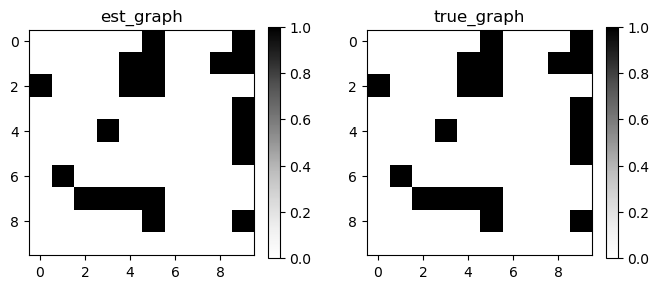

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


In [ ]:
import numpy as np
from castle.algorithms import NotearsLowRank
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
rank = np.linalg.matrix_rank(true_dag)
n = NotearsLowRank()
n.learn(X, rank=rank)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

# DAG-GNN

In [ ]:
# coding = utf-8
# Copyright (C) 2022. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import logging
import numpy as np
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from castle.common import BaseLearner, Tensor
from castle.common import consts
from castle.common.validator import check_args_value

from castle.algorithms.gradient.dag_gnn.torch.utils import functions as func
from castle.algorithms.gradient.dag_gnn.torch.models.modules import Encoder, Decoder


def set_seed(seed):
    """
    Referred from:
    - https://stackoverflow.com/questions/38469632/tensorflow-non-repeatable-results
    """

    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        os.environ['PYTHONHASHSEED'] = str(seed)
    except:
        pass


class DAG_GNN(BaseLearner):
    """DAG Structure Learning with Graph Neural Networks

    References
    ----------
    https://arxiv.org/pdf/1904.10098.pdf

    Parameters
    ----------
    encoder_type: str, default: 'mlp'
        choose an encoder, 'mlp' or 'sem'.
    decoder_type: str, detault: 'mlp'
        choose a decoder, 'mlp' or 'sem'.
    encoder_hidden: int, default: 64
        MLP encoder hidden layer dimension, just one hidden layer.
    latent_dim: int, default equal to input dimension
        encoder output dimension
    decoder_hidden: int, default: 64
        MLP decoder hidden layer dimension, just one hidden layer.
    encoder_dropout: float, default: 0.0
        Dropout rate (1 - keep probability).
    decoder_dropout: float, default: 0.0
        Dropout rate (1 - keep probability).
    epochs: int, default: 300
        train epochs
    k_max_iter: int, default: 1e2
        the max iteration number for searching lambda and c.
    batch_size: int, default: 100
        Sample size of each training batch
    lr: float, default: 3e-3
        learning rate
    lr_decay: int, default: 200
        Period of learning rate decay.
    gamma: float, default: 1.0
        Multiplicative factor of learning rate decay.
    lambda_a: float, default: 0.0
        coefficient for DAG constraint h(A).
    c_a: float, default: 1.0
        coefficient for absolute value h(A).
    c_a_thresh: float, default: 1e20
        control loop by c_a
    eta: int, default: 10
        use for update c_a, greater equal than 1.
    multiply_h: float, default: 0.25
        use for judge whether update c_a.
    tau_a: float, default: 0.0
        coefficient for L-1 norm of A.
    h_tolerance: float, default: 1e-8
        the tolerance of error of h(A) to zero.
    use_a_connect_loss: bool, default: False
        flag to use A connect loss
    use_a_positiver_loss: bool, default: False
        flag to enforce A must have positive values
    graph_threshold: float, default: 0.3
        threshold for learned adjacency matrix binarization.
        greater equal to graph_threshold denotes has causal relationship.
    optimizer: str, default: 'Adam'
        choose optimizer, 'Adam' or 'SGD'
    seed: int, default: 42
        random seed
    device_type: str, default: cpu
        ``cpu`` or ``gpu``
    device_ids: int or str, default None
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str, e.g. 0 or '0',
        For multi-device modules, ``device_ids`` must be str, format like '0, 1'.

    Examples
    --------
    >>> from castle.algorithms.gradient.dag_gnn.torch import DAG_GNN
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> m = DAG_GNN()
    >>> m.learn(X)
    >>> GraphDAG(m.causal_matrix, true_dag)
    >>> met = MetricsDAG(m.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(consts.GNN_VALID_PARAMS)
    def __init__(self, encoder_type='mlp', decoder_type='mlp',
                 encoder_hidden=64, latent_dim=None, decoder_hidden=64,
                 encoder_dropout=0.0, decoder_dropout=0.0, epochs=300, k_max_iter=1e2, tau_a=0.0,
                 batch_size=100, lr=3e-3, lr_decay=200, gamma=1.0, init_lambda_a=0.0, init_c_a=1.0,
                 c_a_thresh=1e20, eta=10, multiply_h=0.25, h_tolerance=1e-8,
                 use_a_connect_loss=False, use_a_positiver_loss=False, graph_threshold=0.3,
                 optimizer='adam', seed=42, device_type='cpu', device_ids='0'):
        super(DAG_GNN, self).__init__()
        self.encoder_type = encoder_type
        self.decoder_type = decoder_type
        self.encoder_hidden = encoder_hidden
        self.latent_dim = latent_dim
        self.decoder_hidden = decoder_hidden
        self.encoder_dropout = encoder_dropout
        self.decoder_dropout = decoder_dropout
        self.epochs = epochs
        self.k_max_iter = int(k_max_iter)
        self.batch_size = batch_size
        self.lr = lr
        self.lr_decay = lr_decay
        self.gamma = gamma
        self.init_lambda_a = init_lambda_a
        self.init_c_a = init_c_a
        self.c_a_thresh = c_a_thresh
        self.eta = eta
        self.multiply_h = multiply_h
        self.tau_a = tau_a
        self.h_tolerance = h_tolerance
        self.use_a_connect_loss = use_a_connect_loss
        self.use_a_positiver_loss = use_a_positiver_loss
        self.graph_threshold = graph_threshold
        self.optimizer = optimizer
        self.seed = seed
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

        self.input_dim = None

    def learn(self, data, columns=None, **kwargs):

        set_seed(self.seed)

        if data.ndim == 2:
            data = np.expand_dims(data, axis=2)
        self.n_samples, self.n_nodes, self.input_dim = data.shape

        if self.latent_dim is None:
            self.latent_dim = self.input_dim
        train_loader = func.get_dataloader(data, batch_size=self.batch_size, device=self.device)

        # =====initialize encoder and decoder=====
        adj_A = torch.zeros((self.n_nodes, self.n_nodes), requires_grad=True, device=self.device)
        self.encoder = Encoder(input_dim=self.input_dim,
                               hidden_dim=self.encoder_hidden,
                               output_dim=self.latent_dim,
                               adj_A=adj_A,
                               device=self.device,
                               encoder_type=self.encoder_type.lower()
                               )
        self.decoder = Decoder(input_dim=self.latent_dim,
                               hidden_dim=self.decoder_hidden,
                               output_dim=self.input_dim,
                               device=self.device,
                               decoder_type=self.decoder_type.lower()
                               )
        # =====initialize optimizer=====
        if self.optimizer.lower() == 'adam':
            optimizer = optim.Adam([{'params': self.encoder.parameters()},
                                    {'params': self.decoder.parameters()}],
                                   lr=self.lr)
        elif self.optimizer.lower() == 'sgd':
            optimizer = optim.SGD([{'params': self.encoder.parameters()},
                                   {'params': self.decoder.parameters()}],
                                  lr=self.lr)
        else:
            raise
        self.scheduler = lr_scheduler.StepLR(optimizer, step_size=self.lr_decay, gamma=self.gamma)

        ################################
        # main training
        ################################
        c_a = self.init_c_a
        lambda_a = self.init_lambda_a
        h_a_new = torch.tensor(1.0)
        h_a_old = np.inf
        elbo_loss = np.inf
        best_elbo_loss = np.inf
        origin_a = adj_A
        epoch = 0
        for step_k in range(self.k_max_iter):
            while c_a < self.c_a_thresh:
                for epoch in range(self.epochs):
                    elbo_loss, origin_a = self._train(train_loader=train_loader,
                                                      optimizer=optimizer,
                                                      lambda_a=lambda_a,
                                                      c_a=c_a)
                    if elbo_loss < best_elbo_loss:
                        best_elbo_loss = elbo_loss
                if elbo_loss > 2 * best_elbo_loss:
                    break
                # update parameters
                a_new = origin_a.detach().clone()
                h_a_new = func._h_A(a_new, self.n_nodes)
                if h_a_new.item() > self.multiply_h * h_a_old:
                    c_a *= self.eta  # eta
                else:
                    break
            # update parameters
            # h_A, adj_A are computed in loss anyway, so no need to store
            h_a_old = h_a_new.item()
            logging.info(f"Iter: {step_k}, epoch: {epoch}, h_new: {h_a_old}")
            lambda_a += c_a * h_a_new.item()
            if h_a_old <= self.h_tolerance:
                break

        origin_a = origin_a.detach().cpu().numpy()
        origin_a[np.abs(origin_a) < self.graph_threshold] = 0
        origin_a[np.abs(origin_a) >= self.graph_threshold] = 1

        self.causal_matrix = Tensor(origin_a, index=columns, columns=columns)

    def _train(self, train_loader, optimizer, lambda_a, c_a):

        self.encoder.train()
        self.decoder.train()

        # update optimizer
        optimizer, lr = func.update_optimizer(optimizer, self.lr, c_a)

        nll_train = []
        kl_train = []
        origin_a = None
        for batch_idx, (data, relations) in enumerate(train_loader):
            x = Variable(data).double()

            optimizer.zero_grad()

            logits, origin_a = self.encoder(x)
            z_gap = self.encoder.z
            z_positive = self.encoder.z_positive
            wa = self.encoder.wa

            x_pred = self.decoder(logits, adj_A=origin_a, wa=wa)    # X_hat

            # reconstruction accuracy loss
            loss_nll = func.nll_gaussian(x_pred, x)

            # KL loss
            loss_kl = func.kl_gaussian_sem(logits)

            # ELBO loss:
            loss = loss_kl + loss_nll

            # add A loss
            one_adj_a = origin_a  # torch.mean(adj_A_tilt_decoder, dim =0)
            sparse_loss = self.tau_a * torch.sum(torch.abs(one_adj_a))

            # other loss term
            if self.use_a_connect_loss:
                connect_gap = func.a_connect_loss(one_adj_a, self.graph_threshold, z_gap)
                loss += lambda_a * connect_gap + 0.5 * c_a * connect_gap * connect_gap

            if self.use_a_positiver_loss:
                positive_gap = func.a_positive_loss(one_adj_a, z_positive)
                loss += .1 * (lambda_a * positive_gap
                              + 0.5 * c_a * positive_gap * positive_gap)
            # compute h(A)
            h_A = func._h_A(origin_a, self.n_nodes)
            loss += (lambda_a * h_A
                     + 0.5 * c_a * h_A * h_A
                     + 100. * torch.trace(origin_a * origin_a)
                     + sparse_loss)  # +  0.01 * torch.sum(variance * variance)
            if np.isnan(loss.detach().cpu().numpy()):
                raise ValueError(f"The loss value is Nan, "
                                 f"suggest to set optimizer='adam' to solve it. "
                                 f"If you already set, please check your code whether has other problems.")
            loss.backward()
            optimizer.step()
            self.scheduler.step()

            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return (np.mean(np.mean(kl_train) + np.mean(nll_train)), origin_a)


# DAG-GNN_Test

In [ ]:
from castle.algorithms.gradient.dag_gnn.torch import DAG_GNN
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
m = DAG_GNN()
m.learn(X)
GraphDAG(m.causal_matrix, true_dag)
met = MetricsDAG(m.causal_matrix, true_dag)
print(met.metrics)

2023-03-31 19:13:54,057 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-03-31 19:13:54,058 - C:\Users\notebook\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.


TypeError: __init__() got an unexpected keyword argument 'device'

# GOLEM

In [ ]:
# coding=utf-8
# 2021.03 modified (1) golem(def) to GOLEM(class)
#                  (2) replace tensorflow with pytorch
# 2021.03 added    (1) get_args, set_seed;
#                  (2) BaseLearner
# 2021.03 deleted  (1) __main__
# Huawei Technologies Co., Ltd.
#
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Copyright (c) Ignavier Ng (https://github.com/ignavier/golem)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import torch
import os

from castle.algorithms.gradient.notears.torch.golem_utils import GolemModel
from castle.algorithms.gradient.notears.torch.golem_utils.train import postprocess
from castle.algorithms.gradient.notears.torch.golem_utils.utils import set_seed

from castle.common import BaseLearner, Tensor


class GOLEM(BaseLearner):
    """
    GOLEM Algorithm.
    A more efficient version of NOTEARS that can reduce number of optimization iterations.

    Paramaters
    ----------
    B_init: None
        File of weighted matrix for initialization. Set to None to disable.
    lambda_1: float
        Coefficient of L1 penalty.
    lambda_2: float
        Coefficient of DAG penalty.
    equal_variances: bool
        Assume equal noise variances for likelibood objective.
    non_equal_variances: bool
        Assume non-equal noise variances for likelibood objective.
    learning_rate: float
        Learning rate of Adam optimizer.
    num_iter: float
        Number of iterations for training.
    checkpoint_iter: int
        Number of iterations between each checkpoint. Set to None to disable.
    seed: int
        Random seed.
    graph_thres: float
        Threshold for weighted matrix.
    device_type: bool
        whether to use GPU or not
    device_ids: int
        choose which gpu to use

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/2006.10201

    Examples
    --------
    >>> from castle.algorithms import GOLEM
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, topology_matrix = load_dataset(name='IID_Test')
    >>> n = GOLEM()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    def __init__(self, B_init=None,
                 lambda_1=2e-2,
                 lambda_2=5.0,
                 equal_variances=True,
                 non_equal_variances=True,
                 learning_rate=1e-3,
                 num_iter=1e+5,
                 checkpoint_iter=5000,
                 seed=1,
                 graph_thres=0.3,
                 device_type='cpu',
                 device_ids=0):

        super().__init__()

        self.B_init = B_init
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.equal_variances = equal_variances
        self.non_equal_variances = non_equal_variances
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.checkpoint_iter = checkpoint_iter
        self.seed = seed
        self.graph_thres = graph_thres
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, **kwargs):
        """
        Set up and run the GOLEM algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        X: numpy.ndarray
            [n, d] data matrix.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        lambda_1: float
            Coefficient of L1 penalty.
        lambda_2: float
            Coefficient of DAG penalty.
        equal_variances: bool
            Whether to assume equal noise variances
            for likelibood objective. Default: True.
        num_iter:int
            Number of iterations for training.
        learning_rate: float
            Learning rate of Adam optimizer. Default: 1e-3.
        seed: int
            Random seed. Default: 1.
        checkpoint_iter: int
            Number of iterations between each checkpoint.
            Set to None to disable. Default: None.
        B_init: numpy.ndarray or None
            [d, d] weighted matrix for initialization.
            Set to None to disable. Default: None.
        """

        X = Tensor(data, columns=columns)

        causal_matrix = self._golem(X)
        self.causal_matrix = Tensor(causal_matrix, index=X.columns,
                                    columns=X.columns)

    def _golem(self, X):
        """
        Solve the unconstrained optimization problem of GOLEM, which involves
        GolemModel and GolemTrainer.

        Parameters
        ----------
        X: numpy.ndarray
            [n, d] data matrix.

        Return
        ------
        B_result: np.ndarray
            [d, d] estimated weighted matrix.

        Hyperparameters
        ---------------
        (1) GOLEM-NV: equal_variances=False, lambda_1=2e-3, lambda_2=5.0.
        (2) GOLEM-EV: equal_variances=True, lambda_1=2e-2, lambda_2=5.0.
        """
        set_seed(self.seed)
        n, d = X.shape
        X = torch.Tensor(X).to(self.device)

        # Set up model
        model = GolemModel(n=n, d=d, lambda_1=self.lambda_1,
                           lambda_2=self.lambda_2,
                           equal_variances=self.equal_variances,
                           B_init=self.B_init,
                           device=self.device)

        self.train_op = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

        logging.info("Started training for {} iterations.".format(int(self.num_iter)))
        for i in range(0, int(self.num_iter) + 1):
            model(X)
            score, likelihood, h, B_est = model.score, model.likelihood, model.h, model.B

            if i > 0:  # Do not train here, only perform evaluation
                # Optimizer
                self.loss = score
                self.train_op.zero_grad()
                self.loss.backward()
                self.train_op.step()

            if self.checkpoint_iter is not None and i % self.checkpoint_iter == 0:
                logging.info("[Iter {}] score={:.3f}, likelihood={:.3f}, h={:.1e}".format( \
                    i, score, likelihood, h))

        # Post-process estimated solution and compute results
        B_processed = postprocess(B_est.cpu().detach().numpy(), graph_thres=0.3)
        B_result = (B_processed != 0).astype(int)

        return B_result


# GOLEM_Test

In [ ]:
from castle.algorithms import GOLEM
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, topology_matrix = load_dataset(name='IID_Test')
n = GOLEM()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 09:46:47,712 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 09:46:47,712 - C:\Users\notebook\castle\algorithms\gradient\notears\torch\golem.py[line:122] - INFO: GPU is unavailable.
2023-04-03 09:46:47,720 - C:\Users\notebook\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 100000 iterations.


AttributeError: module 'torch.linalg' has no attribute 'slogdet'

# GraNDAG_Mindspore_Test

2023-04-03 14:52:44,322 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 14:52:44,324 - C:\Users\notebook\castle\algorithms\gradient\gran_dag\torch\gran_dag.py[line:271] - INFO: GPU is unavailable.
Training Iterations:   0%|                                                                   | 0/10000 [00:00<?, ?it/s]C:\Users\notebook\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Training Iterations: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.34it/s]


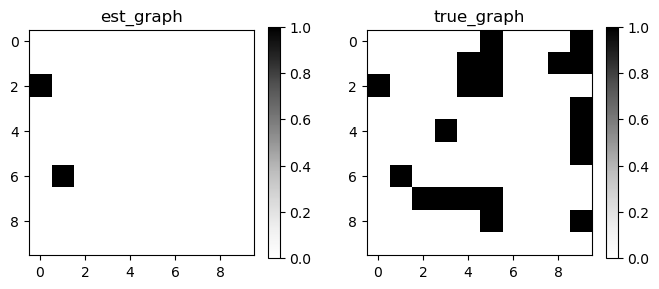

{'fdr': 0.0, 'tpr': 0.1, 'fpr': 0.0, 'shd': 18, 'nnz': 2, 'precision': 1.0, 'recall': 0.1, 'F1': 0.1818, 'gscore': 0.1}


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GraNDAG

# load data
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20,
                                      weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='nonlinear',
                        sem_type='mlp')
dag, x = dataset.B, dataset.X

# Instantiation algorithm
d = {'model_name': 'NonLinGauss', 'nonlinear': 'leaky-relu', 'optimizer': 'sgd', 'norm_prod': 'paths', 'device_type': 'gpu'}
gnd = GraNDAG(input_dim=x.shape[1], )
gnd.learn(data=x)

# plot predict_dag and true_dag
GraphDAG(gnd.causal_matrix, dag)
mm = MetricsDAG(gnd.causal_matrix, dag)
print(mm.metrics)

# GraNDAG_Torch

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import logging
import torch
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

from castle.algorithms.gradient.gran_dag.torch.base import NonlinearGauss
from castle.algorithms.gradient.gran_dag.torch.base import NonlinearGaussANM
from castle.algorithms.gradient.gran_dag.torch.base import compute_constraint
from castle.algorithms.gradient.gran_dag.torch.base import compute_jacobian_avg
from castle.algorithms.gradient.gran_dag.torch.base import is_acyclic

from castle.common import BaseLearner, Tensor
from castle.common.validator import check_args_value
from castle.common.consts import GRANDAG_VALID_PARAMS
#gcastle/castle/algorithms/gradient/gran_dag/torch/base/base_model.py

class NormalizationData(object):
    """
    Create Normalization Data object

    Parameters
    ----------
    data : numpy.ndarray
        train x
    normalize : bool, default False
        whether normalization
    mean : float or None default None
        Mean value of normalization
    std : float or None default None
        Standard Deviation of normalization
    shuffle : bool
        whether shuffle
    train_size : float, default 0.8
        ratio of train data for training
    train : bool, default True
        whether training
    random_seed : int
        for set random seed
    """

    def __init__(self, data, normalize=False, mean=None, std=None,
                 shuffle=False, train_size=0.8, train=True, random_seed=42):
        self.random = np.random.RandomState(random_seed)

        shuffle_idx = np.arange(data.shape[0])
        if shuffle:
            self.random.shuffle(shuffle_idx)

        if isinstance(train_size, float):
            train_samples = int(data.shape[0] * train_size)
        else:
            raise TypeError("The param train_size must be float < 1")
        if train:
            data = data[shuffle_idx[: train_samples]]
        else:
            data = data[shuffle_idx[train_samples:]]
        # as tensor
        self.data_set = torch.as_tensor(data).type(torch.Tensor)

        # Normalize data
        self.mean, self.std = mean, std
        if normalize:
            if mean is None or std is None:
                self.mean = torch.mean(self.data_set, 0, keepdim=True)
                self.std = torch.std(self.data_set, 0, keepdim=True)
            self.data_set = (self.data_set - self.mean) / self.std
        self.n_samples = self.data_set.size(0)

    def sample(self, batch_size):
        """sampling from self.dataset

        Parameters
        ----------
        batch_size : int
            batch size of sample

        Returns
        -------
        samples : torch.Tensor
            sample data after sampling
        torch.ones_like(samples): torch.Tensor
        """
        sample_idxs = self.random.choice(np.arange(int(self.n_samples)),
                                         size=(int(batch_size),),
                                         replace=False)
        samples = self.data_set[torch.as_tensor(sample_idxs).long()]

        return samples, torch.ones_like(samples)


class GraNDAG(BaseLearner):
    """
    Gradient Based Neural DAG Learner

    A gradient-based algorithm using neural network modeling for
    non-linear additive noise data

    References: https://arxiv.org/pdf/1906.02226.pdf

    Parameters
    ----------
    input_dim : int
        number of input layer, must be int
    hidden_num : int, default 2
        number of hidden layers
    hidden_dim : int, default 10
        number of dimension per hidden layer
    batch_size : int, default 64
        batch size of per training of NN
    lr : float, default 0.001
        learning rate
    iterations : int, default 10000
        times of iteration
    model_name : str, default 'NonLinGaussANM'
        name of model, 'NonLinGauss' or 'NonLinGaussANM'
    nonlinear : str, default 'leaky-relu'
        name of Nonlinear activation function, 'sigmoid' or 'leaky-relu'
    optimizer : str, default 'rmsprop'
        Method of optimize, `rmsprop` or `sgd`
    h_threshold : float, default 1e-8
        constrained threshold
    device_type : str, default 'cpu'
        use gpu or cpu
    use_pns : bool, default False
        whether use pns before training, if nodes > 50, use it.
    pns_thresh : float, default 0.75
        threshold for feature importance score in pns
    num_neighbors : int, default None
        number of potential parents for each variables
    normalize : bool, default False
        whether normalize data
    precision : bool, default False
        whether use Double precision
        if True, use torch.FloatTensor; if False, use torch.DoubleTensor
    random_seed : int, default 42
        random seed
    norm_prod : str, default 'paths'
        use norm of product of paths, 'none' or 'paths'
        'paths': use norm, 'none': with no norm
    square_prod : bool, default False
        use squared product of paths
    jac_thresh : bool, default True
        get the average Jacobian with the trained model
    lambda_init : float, default 0.0
        initialization of Lagrangian coefficient in the optimization of
        augmented Lagrangian
    mu_init : float, default 0.001
        initialization of penalty coefficient in the optimization of
        augmented Lagrangian
    omega_lambda : float, default 0.0001
        tolerance on the delta lambda, to find saddle points
    omega_mu : float, default 0.9
        check whether the constraint decreases sufficiently if it decreases
        at least (1-omega_mu) * h_prev
    stop_crit_win : int, default 100
        number of iterations for updating values
    edge_clamp_range : float, default 0.0001
        threshold for keeping the edge (if during training)

    Examples
    --------
        Load data
    >>> from castle.datasets import load_dataset
    >>> data, true_dag, _ = load_dataset('IID_Test')

    >>> gnd = GraNDAG(input_dim=data.shape[1])
    >>> gnd.learn(data=data)

        Also print GraN_DAG.model.adjacency with torch.Tensor type
        or print GranN_DAG.causal_matrix with numpy.ndarray.
    >>> print(gnd.causal_matrix)
    >>> print(gnd.model.adjacency)
    """

    @check_args_value(GRANDAG_VALID_PARAMS)
    def __init__(self, input_dim,
                 hidden_num=2,
                 hidden_dim=10,
                 batch_size=64,
                 lr=0.001,
                 iterations=10000,
                 model_name='NonLinGaussANM',
                 nonlinear='leaky-relu',
                 optimizer='rmsprop',
                 h_threshold=1e-8,
                 device_type='cpu',
                 device_ids='0',
                 use_pns=False,
                 pns_thresh=0.75,
                 num_neighbors=None,
                 normalize=False,
                 precision=False,
                 random_seed=42,
                 jac_thresh=True,
                 lambda_init=0.0,
                 mu_init=0.001,
                 omega_lambda=0.0001,
                 omega_mu=0.9,
                 stop_crit_win=100,
                 edge_clamp_range=0.0001,
                 norm_prod='paths',
                 square_prod=False):
        super(GraNDAG, self).__init__()

        self.input_dim = input_dim
        self.hidden_num = hidden_num
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.iterations = iterations
        self.model_name = model_name
        self.nonlinear = nonlinear
        self.optimizer = optimizer
        self.h_threshold = h_threshold
        self.device_type = device_type
        self.device_ids = device_ids
        self.use_pns = use_pns
        self.pns_thresh = pns_thresh
        self.num_neighbors = num_neighbors
        self.normalize = normalize
        self.precision = precision
        self.random_seed = random_seed
        self.jac_thresh = jac_thresh
        self.lambda_init = lambda_init
        self.mu_init = mu_init
        self.omega_lambda = omega_lambda
        self.omega_mu = omega_mu
        self.stop_crit_win = stop_crit_win
        self.edge_clamp_range = edge_clamp_range
        self.norm_prod = norm_prod
        self.square_prod = square_prod

    def learn(self, data, columns=None, **kwargs):
        """Set up and run the Gran-DAG algorithm

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            include Tensor.data
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        """

        # Control as much randomness as possible
        torch.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)

        # Use gpu
        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.precision:
                torch.set_default_tensor_type('torch.cuda.FloatTensor')
            else:
                torch.set_default_tensor_type('torch.cuda.DoubleTensor')
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            if self.precision:
                torch.set_default_tensor_type('torch.FloatTensor')
            else:
                torch.set_default_tensor_type('torch.DoubleTensor')
            device = torch.device('cpu')
        self.device = device

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        if data.shape[1] != self.input_dim:
            raise ValueError("The number of variables is `{}`, "
                             "the param input_dim is `{}`, "
                             "they must be consistent"
                             ".".format(data.shape[1], self.input_dim))

        if self.model_name == "NonLinGauss":
            self.model = NonlinearGauss(input_dim=self.input_dim,
                                        hidden_num=self.hidden_num,
                                        hidden_dim=self.hidden_dim,
                                        output_dim=2,
                                        nonlinear=self.nonlinear,
                                        norm_prod=self.norm_prod,
                                        square_prod=self.square_prod)
        elif self.model_name == "NonLinGaussANM":
            self.model = NonlinearGaussANM(input_dim=self.input_dim,
                                           hidden_num=self.hidden_num,
                                           hidden_dim=self.hidden_dim,
                                           output_dim=1,
                                           nonlinear=self.nonlinear,
                                           norm_prod=self.norm_prod,
                                           square_prod=self.square_prod)
        else:
            raise ValueError(
                "self.model has to be in {NonLinGauss, NonLinGaussANM}")

        # create NormalizationData
        train_data = NormalizationData(data, train=True,
                                       normalize=self.normalize)
        test_data = NormalizationData(data, train=False,
                                      normalize=self.normalize,
                                      mean=train_data.mean,
                                      std=train_data.std)

        # apply preliminary neighborhood selection if input_dim > 50
        if self.use_pns:
            if self.num_neighbors is None:
                num_neighbors = self.input_dim
            else:
                num_neighbors = self.num_neighbors

            self.model = neighbors_selection(model=self.model, all_samples=data,
                                             num_neighbors=num_neighbors,
                                             thresh=self.pns_thresh)

        # update self.model by train
        self._train(train_data=train_data, test_data=test_data)

        # update self.model by run _to_dag
        self._to_dag(train_data)

        self._causal_matrix = Tensor(self.model.adjacency.detach().cpu().numpy(),
                                     index=data.columns,
                                     columns=data.columns)

    def _train(self, train_data, test_data):
        """
        Applying augmented Lagrangian to solve the continuous constrained problem.

        Parameters
        ----------
        train_data: NormalizationData
            train samples
        test_data: NormalizationData object
            test samples for validation
        """

        # initialize stuff for learning loop
        aug_lagrangians = []
        aug_lagrangian_ma = [0.0] * (self.iterations + 1)
        aug_lagrangians_val = []
        grad_norms = []
        grad_norm_ma = [0.0] * (self.iterations + 1)

        w_adjs = np.zeros((self.iterations,
                           self.input_dim,
                           self.input_dim), dtype=np.float32)

        hs = []
        not_nlls = []  # Augmented Lagrangian minus (pseudo) NLL
        nlls = []  # NLL on train
        nlls_val = []  # NLL on validation

        # Augmented Lagrangian stuff
        mu = self.mu_init
        lamb = self.lambda_init
        mus = []
        lambdas = []

        if self.optimizer == "sgd":
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "rmsprop":
            optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("optimizer {} is not implemented"
                                      .format(self.optimizer))

        # Learning loop:
        for iter in tqdm(range(self.iterations), desc='Training Iterations'):
            # compute loss
            self.model.train()
            x, _ = train_data.sample(self.batch_size)
            # Initialize weights and bias
            weights, biases, extra_params = self.model.get_parameters(mode="wbx")
            loss = - torch.mean(
                self.model.compute_log_likelihood(x, weights, biases, extra_params))
            nlls.append(loss.item())
            self.model.eval()

            # constraint related
            w_adj = self.model.get_w_adj()
            h = compute_constraint(self.model, w_adj)

            # compute augmented Lagrangian
            aug_lagrangian = loss + 0.5 * mu * h ** 2 + lamb * h

            # optimization step on augmented lagrangian
            optimizer.zero_grad()
            aug_lagrangian.backward()
            optimizer.step()

            # clamp edges
            if self.edge_clamp_range != 0:
                with torch.no_grad():
                    to_keep = (w_adj > self.edge_clamp_range) * 1
                    self.model.adjacency *= to_keep

            # logging
            w_adjs[iter, :, :] = w_adj.detach().cpu().numpy().astype(np.float32)
            mus.append(mu)
            lambdas.append(lamb)
            not_nlls.append(0.5 * mu * h.item() ** 2 + lamb * h.item())

            # compute augmented lagrangian moving average
            aug_lagrangians.append(aug_lagrangian.item())
            aug_lagrangian_ma[iter + 1] = aug_lagrangian_ma[iter] + \
                                          0.01 * (aug_lagrangian.item() -
                                                  aug_lagrangian_ma[iter])
            grad_norms.append(self.model.get_grad_norm("wbx").item())
            grad_norm_ma[iter + 1] = grad_norm_ma[iter] + \
                                     0.01 * (grad_norms[-1] - grad_norm_ma[iter])

            # compute loss on whole validation set
            if iter % self.stop_crit_win == 0:
                with torch.no_grad():
                    x, _ = test_data.sample(test_data.n_samples)
                    loss_val = - torch.mean(self.model.compute_log_likelihood(x,
                                                                 weights,
                                                                 biases,
                                                                 extra_params))
                    nlls_val.append(loss_val.item())
                    aug_lagrangians_val.append([iter, loss_val + not_nlls[-1]])

            # compute delta for lambda
            if iter >= 2 * self.stop_crit_win \
                    and iter % (2 * self.stop_crit_win) == 0:
                t0 = aug_lagrangians_val[-3][1]
                t_half = aug_lagrangians_val[-2][1]
                t1 = aug_lagrangians_val[-1][1]

                # if the validation loss went up and down,
                # do not update lagrangian and penalty coefficients.
                if not (min(t0, t1) < t_half < max(t0, t1)):
                    delta_lambda = -np.inf
                else:
                    delta_lambda = (t1 - t0) / self.stop_crit_win
            else:
                delta_lambda = -np.inf  # do not update lambda nor mu

            # Does the augmented lagrangian converged?
            if h > self.h_threshold:
                # if we have found a stationary point of the augmented loss
                if abs(delta_lambda) < self.omega_lambda or delta_lambda > 0:
                    lamb += mu * h.item()

                    # Did the constraint improve sufficiently?
                    hs.append(h.item())
                    if len(hs) >= 2:
                        if hs[-1] > hs[-2] * self.omega_mu:
                            mu *= 10

                    # little hack to make sure the moving average is going down.
                    with torch.no_grad():
                        gap_in_not_nll = 0.5 * mu * h.item() ** 2 + \
                                         lamb * h.item() - not_nlls[-1]
                        aug_lagrangian_ma[iter + 1] += gap_in_not_nll
                        aug_lagrangians_val[-1][1] += gap_in_not_nll

                    if self.optimizer == "rmsprop":
                        optimizer = torch.optim.RMSprop(self.model.parameters(),
                                                        lr=self.lr)
                    else:
                        optimizer = torch.optim.SGD(self.model.parameters(),
                                                    lr=self.lr)
            else:
                # Final clamping of all edges == 0
                with torch.no_grad():
                    to_keep = (w_adj > 0).type(torch.Tensor)
                    self.model.adjacency *= to_keep

                return self.model

    def _to_dag(self, train_data):
        """
        1- If some entries of A_\phi == 0, also mask them
        (This can happen with stochastic proximal gradient descent)
        2- Remove edges (from weaker to stronger) until a DAG is obtained.

        Parameters
        ----------
        train_data : NormalizationData
            train samples
        """

        self.model.eval()

        if self.jac_thresh:
            A = compute_jacobian_avg(self.model, train_data,
                                     train_data.n_samples).t()
        else:
            A = self.model.get_w_adj()
        A = A.detach().cpu().numpy()

        with torch.no_grad():
            # Find the smallest threshold that removes all cycle-inducing edges
            thresholds = np.unique(A)
            epsilon = 1e-8
            for step, t in enumerate(thresholds):
                to_keep = torch.Tensor(A > t + epsilon)
                new_adj = self.model.adjacency * to_keep
                if is_acyclic(new_adj, device=self.device):
                    self.model.adjacency.copy_(new_adj)
                    break

        return self.model


def neighbors_selection(model, all_samples, num_neighbors, thresh):
    """
    Preliminary neighborhood selection
    After pns, just model.adjacency is changed. if nodes > 50, use it.

    Parameters
    ----------
    model: model object
    all_samples: array-like
        2 dimensional array include all samples
    num_neighbors: integer
        variable number or neighbors number you want
    thresh: float
        apply for sklearn.feature_selection.SelectFromModel

    Returns
    -------
    out: model
    """

    model_adj = model.adjacency.detach().cpu().numpy()
    model_adj = _pns(model_adj, all_samples, num_neighbors, thresh)
    with torch.no_grad():
        model.adjacency.copy_(torch.Tensor(model_adj))

    return model


def _pns(model_adj, all_samples, num_neighbors, thresh):
    """Preliminary neighborhood selection

    Parameters
    ----------
    model_adj : numpy.ndarray
        adjacency matrix, all element is 1
    all_samples: numpy.ndarray
        2 dimensional array include all samples
    num_neighbors: integer
        variable number or neighbors number you want
    thresh: float
        apply for sklearn.feature_selection.SelectFromModel

    Returns
    -------
    model_adj : numpy.ndarray
        adjacency matrix, after pns process
    """

    num_nodes = all_samples.shape[1]

    for node in tqdm(range(num_nodes), desc='Preliminary neighborhood selection'):
        x_other = np.copy(all_samples)
        x_other[:, node] = 0
        extraTree = ExtraTreesRegressor(n_estimators=500)
        extraTree.fit(x_other, all_samples[:, node])
        selected_reg = SelectFromModel(extraTree,
                                       threshold="{}*mean".format(thresh),
                                       prefit=True,
                                       max_features=num_neighbors)
        mask_selected = selected_reg.get_support(indices=False)
        model_adj[:, node] *= mask_selected

    return model_adj


# GraNDAG_Torch_Test

In [ ]:
from castle.datasets import load_dataset
data, true_dag, _ = load_dataset('IID_Test')

gnd = GraNDAG(input_dim=data.shape[1])
gnd.learn(data=data)

print(gnd.causal_matrix)
print(gnd.model.adjacency)

2023-04-03 12:05:37,800 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 12:05:37,800 - C:\Users\notebook\AppData\Local\Temp\ipykernel_10824\4249829128.py[line:271] - INFO: GPU is unavailable.
Training Iterations:   0%|                                                                   | 0/10000 [00:00<?, ?it/s]C:\Users\notebook\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Training Iterations: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 140.94it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


# MCSL

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import logging
import random
import numpy as np
import torch

from castle.common.base import BaseLearner, Tensor
from castle.algorithms.gradient.mcsl.torch.trainers.al_trainer import Trainer
from castle.algorithms.gradient.mcsl.torch.models.masked_model import MaskedModel
from castle.algorithms.gradient.mcsl.torch.helpers.utils import callback_after_training
from castle.common.consts import MCSL_VALID_PARAMS
from castle.common.validator import check_args_value


def set_seed(seed):
    """
    Referred from:
    - https://stackoverflow.com/questions/38469632/tensorflow-non-repeatable-results
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        os.environ['PYTHONHASHSEED'] = str(seed)
    finally:
        pass


class MCSL(BaseLearner):
    """
    Masked Gradient-Based Causal Structure Learning

    A gradient-based algorithm for non-linear additive noise data by learning
    the binary adjacency matrix.

    Parameters
    ----------
    model_type: str, default: 'nn'
        `nn` denotes neural network, `qr` denotes quatratic regression.
    num_hidden_layers: int, default: 4
        Number of hidden layer in neural network when `model_type` is 'nn'.
    hidden_dim: int, default: 16
        Number of hidden dimension in hidden layer, when `model_type` is 'nn'.
    graph_thresh: float, default: 0.5
        Threshold used to determine whether has edge in graph, element greater
        than the `graph_thresh` means has a directed edge, otherwise has not.
    l1_graph_penalty: float, default: 2e-3
        Penalty weight for L1 normalization
    learning_rate: float, default: 3e-2
        learning rate for opitimizer
    max_iter: int, default: 25
        Number of iterations for optimization problem
    iter_step: int, default: 1000
        Number of steps for each iteration
    init_iter: int, default: 2
        Initial iteration to disallow early stopping
    h_tol: float, default: 1e-10
        Tolerance of optimization problem
    init_rho: float, default: 1e-5
        Initial value for penalty parameter.
    rho_thresh: float, default: 1e14
        Threshold for penalty parameter.
    h_thresh: float, default: 0.25
        Threshold for h
    rho_multiply: float, default: 10.0
        Multiplication to amplify rho each time
    temperature: float, default: 0.2
        Temperature for gumbel sigmoid
    device_type: str, default: 'cpu'
        'cpu' or 'gpu'
    device_ids: int or str, default '0'
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str, e.g. 0 or '0',
        For multi-device modules, ``device_ids`` must be str, format like '0, 1'.
    random_seed: int, default: 1230
        random seed for every random value

    References
    ----------
    https://arxiv.org/abs/1910.08527

    Examples
    --------
    >>> from castle.algorithms import MCSL
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> true_dag, X = load_dataset(name='iid_test')
    >>> n = MCSL(iter_step=1000, rho_thres=1e14, init_rho=1e-5,
    ...          rho_multiply=10, graph_thres=0.5, l1_graph_penalty=2e-3)
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(MCSL_VALID_PARAMS)
    def __init__(self, model_type='nn', num_hidden_layers=4, hidden_dim=16,
                 graph_thresh=0.5, l1_graph_penalty=2e-3, learning_rate=3e-2,
                 max_iter=25, iter_step=1000, init_iter=2, h_tol=1e-10,
                 init_rho=1e-5, rho_thresh=1e14, h_thresh=0.25,
                 rho_multiply=10, temperature=0.2, device_type='cpu',
                 device_ids='0', random_seed=1230) -> None:
        super(MCSL, self).__init__()

        self.model_type = model_type
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dim = hidden_dim
        self.graph_thresh = graph_thresh
        self.l1_graph_penalty = l1_graph_penalty
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.iter_step = iter_step
        self.init_iter = init_iter
        self.h_tol = h_tol
        self.init_rho = init_rho
        self.rho_thresh = rho_thresh
        self.h_thresh = h_thresh
        self.rho_multiply = rho_multiply
        self.temperature = temperature
        self.device_type = device_type
        self.device_ids = device_ids
        self.random_seed = random_seed

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, pns_mask=None, **kwargs) -> None:
        """
        Set up and run the MCSL algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns: Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        pns_mask: array_like or None
            The mask matrix.
            array with element in {0, 1}, ``0`` denotes has no edge in i -> j,
            ``1`` denotes maybe has edge in i -> j or not.
        """

        x = Tensor(data, columns=columns)

        self.n_samples, self.n_nodes = x.shape
        if pns_mask is None:
            pns_mask = torch.ones([x.shape[1], x.shape[1]], device=self.device)
        else:
            pns_mask = torch.tensor(pns_mask, device=self.device)

        causal_matrix, causal_matrix_weight = self._mcsl(x, pns_mask)

        self.causal_matrix_weight = Tensor(causal_matrix_weight,
                                           index=x.columns,
                                           columns=x.columns
                                           )
        self.causal_matrix = Tensor(causal_matrix,
                                    index=x.columns,
                                    columns=x.columns
                                    )

    def _mcsl(self, x, pns_mask) -> tuple:
        """
        Starting model of MCSL.

        Parameters
        ----------
        x: torch.Tensor
            The torch.Tensor data you want to learn.
        pns_mask: torch.Tensor
            The mask matrix.
        """

        set_seed(self.random_seed)

        model = MaskedModel(model_type=self.model_type,
                            n_samples=self.n_samples,
                            n_nodes=self.n_nodes,
                            pns_mask=pns_mask,
                            num_hidden_layers=self.num_hidden_layers,
                            hidden_dim=self.hidden_dim,
                            l1_graph_penalty=self.l1_graph_penalty,
                            seed=self.random_seed,
                            device=self.device)
        trainer = Trainer(model=model,
                          learning_rate=self.learning_rate,
                          init_rho=self.init_rho,
                          rho_thresh=self.rho_thresh,
                          h_thresh=self.h_thresh,
                          rho_multiply=self.rho_multiply,
                          init_iter=self.init_iter,
                          h_tol=self.h_tol,
                          temperature=self.temperature,
                          device=self.device)

        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device)
        w_logits = trainer.train(x, self.max_iter, self.iter_step)

        w_est, w_est_weight = callback_after_training(w_logits,
                                                      self.temperature,
                                                      self.graph_thresh)
        return w_est.detach().cpu().numpy(), w_est_weight.detach().cpu().numpy()


# MCSL_Test

In [ ]:
from castle.algorithms import MCSL
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

X, true_dag, _ = load_dataset(name='IID_Test')

n = MCSL(iter_step=1000, init_rho=1e-5,rho_multiply=10, l1_graph_penalty=2e-3)
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 12:39:56,246 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 12:39:56,247 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\mcsl.py[line:144] - INFO: GPU is unavailable.
2023-04-03 12:39:56,261 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\trainers\al_trainer.py[line:58] - INFO: Current epoch: 1==================
2023-04-03 12:39:56,314 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\trainers\al_trainer.py[line:97] - INFO: Current loss in step 0: 172.21960756363447
2023-04-03 12:40:04,322 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\trainers\al_trainer.py[line:97] - INFO: Current loss in step 200: 2.0705390402262447
2023-04-03 12:40:12,116 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\trainers\al_trainer.py[line:97] - INFO: Current loss in step 400: 1.756680084647887
2023-04-03 12:40:19,920 - C:\Users\notebook\castle\algorithms\gradient\mcsl\torch\trainers\al_train

# GAE

In [ ]:
# coding=utf-8
# Copyright (C) 2022. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import random
import torch
import logging
import numpy as np

from castle.common import BaseLearner, Tensor
from castle.algorithms.gradient.gae.torch.trainers.al_trainer import ALTrainer
from castle.algorithms.gradient.gae.torch.models.model import AutoEncoder


def set_seed(seed):
    """
    Referred from:
    - https://stackoverflow.com/questions/38469632/tensorflow-non-repeatable-results
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        os.environ['PYTHONHASHSEED'] = str(seed)
    except Exception:
        pass


class GAE(BaseLearner):
    """
    GAE Algorithm.
    A gradient-based algorithm using graph autoencoder to model non-linear
    causal relationships.

    Parameters
    ----------
    input_dim: int, default: 1
        dimension of vector for x
    hidden_layers: int, default: 1
        number of hidden layers for encoder and decoder
    hidden_dim: int, default: 4
        hidden size for mlp layer
    activation: callable, default: nn.LeakyReLU(0.05)
        nonlinear functional
    epochs: int, default: 10
        Number of iterations for optimization problem
    update_freq: int, default: 3000
        Number of steps for each iteration
    init_iter: int, default: 3
        Initial iteration to disallow early stopping
    lr: float, default: 1e-3
        learning rate
    alpha: float, default: 0.0
        Lagrange multiplier
    beta: float, default: 2.0
        Multiplication to amplify rho each time
    init_rho: float, default: 1.0
        Initial value for rho
    rho_thresh: float, default: 1e30
        Threshold for rho
    gamma: float, default: 0.25
        Threshold for h
    penalty_lambda: float, default: 0.0
        L1 penalty for sparse graph. Set to 0.0 to disable
    h_thresh: float, default: 1e-8
        Tolerance of optimization problem
    graph_thresh: float, default: 0.3
        Threshold to filter out small values in graph
    early_stopping: bool, default: False
        Whether to use early stopping
    early_stopping_thresh: float, default: 1.0
        Threshold ratio for early stopping
    seed: int, default: 1230
        Reproducibility, must be int
    device_type: str, default: 'cpu'
        'cpu' or 'gpu'
    device_ids: int or str, default '0'
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str,
        e.g. 0 or '0', For multi-device modules, ``device_ids`` must be str,
        format like '0, 1'.
    """

    def __init__(self,
                 input_dim=1,
                 hidden_layers=1,
                 hidden_dim=4,
                 activation=torch.nn.LeakyReLU(0.05),
                 epochs=10,
                 update_freq=3000,
                 init_iter=3,
                 lr=1e-3,
                 alpha=0.0,
                 beta=2.0,
                 init_rho=1.0,
                 rho_thresh=1e30,
                 gamma=0.25,
                 penalty_lambda=0.0,
                 h_thresh=1e-8,
                 graph_thresh=0.3,
                 early_stopping=False,
                 early_stopping_thresh=1.0,
                 seed=1230,
                 device_type='cpu',
                 device_ids='0'):

        super(GAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.epochs = epochs
        self.update_freq = update_freq
        self.init_iter = init_iter
        self.lr = lr
        self.alpha = alpha
        self.beta = beta
        self.init_rho = init_rho
        self.rho_thresh = rho_thresh
        self.gamma = gamma
        self.penalty_lambda = penalty_lambda
        self.h_thresh = h_thresh
        self.graph_thresh = graph_thresh
        self.early_stopping = early_stopping
        self.early_stopping_thresh = early_stopping_thresh
        self.seed = seed
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, **kwargs):

        x = torch.from_numpy(data)

        self.n, self.d = x.shape[:2]
        if x.ndim == 2:
            x = x.reshape((self.n, self.d, 1))
            self.input_dim = 1
        elif x.ndim == 3:
            self.input_dim = x.shape[2]

        w_est = self._gae(x).detach().cpu().numpy()

        self.weight_causal_matrix = Tensor(w_est,
                                           index=columns,
                                           columns=columns)
        causal_matrix = (abs(w_est) > self.graph_thresh).astype(int)
        self.causal_matrix = Tensor(causal_matrix,
                                    index=columns,
                                    columns=columns)

    def _gae(self, x):

        set_seed(self.seed)
        model = AutoEncoder(d=self.d,
                            input_dim=self.input_dim,
                            hidden_layers=self.hidden_layers,
                            hidden_dim=self.hidden_dim,
                            activation=self.activation,
                            device=self.device,
                            )
        trainer = ALTrainer(n=self.n,
                            d=self.d,
                            model=model,
                            lr=self.lr,
                            init_iter=self.init_iter,
                            alpha=self.alpha,
                            beta=self.beta,
                            rho=self.init_rho,
                            l1_penalty=self.penalty_lambda,
                            rho_thresh=self.rho_thresh,
                            h_thresh=self.h_thresh,  # 1e-8
                            early_stopping=self.early_stopping,
                            early_stopping_thresh=self.early_stopping_thresh,
                            gamma=self.gamma,
                            seed=self.seed,
                            device=self.device)
        w_est = trainer.train(x=x,
                              epochs=self.epochs,
                              update_freq=self.update_freq)
        w_est = w_est / torch.max(abs(w_est))

        return w_est


2023-04-03 13:07:02,319 - C:\Users\notebook\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-04-03 13:07:03,485 - C:\Users\notebook\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# GAE_Test

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GAE


#######################################
# graph_auto_encoder used simulate data
#######################################
# simulate data for graph-auto-encoder
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

ga = GAE(input_dim=10)
ga.learn(X)

# plot est_dag and true_dag
GraphDAG(ga.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(ga.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 13:10:18,139 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 13:10:18,141 - C:\Users\notebook\castle\algorithms\gradient\gae\torch\gae.py[line:146] - INFO: GPU is unavailable.


TypeError: __init__() got an unexpected keyword argument 'device'

# RL

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import logging
from tqdm import tqdm
import platform
import torch
import numpy as np

from castle.algorithms.gradient.rl.torch.data_loader import DataGenerator_read_data
from castle.algorithms.gradient.rl.torch.models import Actor
from castle.algorithms.gradient.rl.torch.rewards import get_Reward
from castle.algorithms.gradient.rl.torch.helpers.torch_utils import set_seed
from castle.algorithms.gradient.rl.torch.helpers.lambda_utils import BIC_lambdas
from castle.algorithms.gradient.rl.torch.helpers.analyze_utils import convert_graph_int_to_adj_mat,graph_prunned_by_coef, graph_prunned_by_coef_2nd

from castle.common import BaseLearner, Tensor
from castle.metrics import MetricsDAG
from castle.common.consts import RL_VALID_PARAMS
from castle.common.validator import check_args_value


class RL(BaseLearner):
    """
    RL Algorithm.
    A RL-based algorithm that can work with flexible score functions (including non-smooth ones).

    Parameters
    ----------
    encoder_type: str
        type of encoder used
    hidden_dim: int
        actor LSTM num_neurons
    num_heads: int
        actor input embedding
    num_stacks: int
        actor LSTM num_neurons
    residual: bool
        whether to use residual for gat encoder
    decoder_type: str
        type of decoder used
    decoder_activation: str
        activation for decoder
    decoder_hidden_dim: int
        hidden dimension for decoder
    use_bias: bool
        Whether to add bias term when calculating decoder logits
    use_bias_constant: bool
        Whether to add bias term as CONSTANT when calculating decoder logits
    bias_initial_value: float
        Initial value for bias term when calculating decoder logits
    batch_size: int
        batch size for training
    input_dimension: int
        dimension of reshaped vector
    normalize: bool
        whether the inputdata shall be normalized
    transpose: bool
        whether the true graph needs transposed
    score_type: str
        score functions
    reg_type: str
        regressor type (in combination wth score_type)
    lambda_iter_num: int
        how often to update lambdas
    lambda_flag_default: bool
        with set lambda parameters; true with default strategy and ignore input bounds
    score_bd_tight: bool
        if bound is tight, then simply use a fixed value, rather than the adaptive one
    lambda1_update: float
        increasing additive lambda1
    lambda2_update: float
        increasing  multiplying lambda2
    score_lower: float
        lower bound on lambda1
    score_upper: float
        upper bound on lambda1
    lambda2_lower: float
        lower bound on lambda2
    lambda2_upper: float
        upper bound on lambda2
    seed: int
        seed
    nb_epoch: int
        nb epoch
    lr1_start: float
        actor learning rate
    lr1_decay_step: int
        lr1 decay step
    lr1_decay_rate: float
        lr1 decay rate
    alpha: float
        update factor moving average baseline
    init_baseline: float
        initial baseline - REINFORCE
    temperature: float
        pointer_net initial temperature
    C: float
        pointer_net tan clipping
    l1_graph_reg: float
        L1 graph regularization to encourage sparsity
    inference_mode: bool
        switch to inference mode when model is trained
    verbose: bool
        print detailed logging or not
    device_type: str
        whether to use GPU or not
    device_ids: int
        choose which gpu to use

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/1906.04477

    Examples
    --------
    >>> from castle.algorithms import RL
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> n = RL()
    >>> n.learn(X, dag=true_dag)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(RL_VALID_PARAMS)
    def __init__(self, encoder_type='TransformerEncoder',
                 hidden_dim=64,
                 num_heads=16,
                 num_stacks=6,
                 residual=False,
                 decoder_type='SingleLayerDecoder',
                 decoder_activation='tanh',
                 decoder_hidden_dim=16,
                 use_bias=False,
                 use_bias_constant=False,
                 bias_initial_value=False,
                 batch_size=64,
                 input_dimension=64,
                 normalize=False,
                 transpose=False,
                 score_type='BIC',
                 reg_type='LR',
                 lambda_iter_num=1000,
                 lambda_flag_default=True,
                 score_bd_tight=False,
                 lambda2_update=10,
                 score_lower=0.0,
                 score_upper=0.0,
                 seed=8,
                 nb_epoch=20000,
                 lr1_start=0.001,
                 lr1_decay_step=5000,
                 lr1_decay_rate=0.96,
                 alpha=0.99,
                 init_baseline=-1.0,
                 l1_graph_reg=0.0,
                 verbose=False,
                 device_type='cpu',
                 device_ids=0):

        super().__init__()

        self.encoder_type = encoder_type
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_stacks = num_stacks
        self.residual = residual
        self.decoder_type = decoder_type
        self.decoder_activation = decoder_activation
        self.decoder_hidden_dim = decoder_hidden_dim
        self.use_bias = use_bias
        self.use_bias_constant = use_bias_constant
        self.bias_initial_value = bias_initial_value
        self.batch_size = batch_size
        self.input_dimension = input_dimension
        self.normalize = normalize
        self.transpose = transpose
        self.score_type = score_type
        self.reg_type = reg_type
        self.lambda_iter_num = lambda_iter_num
        self.lambda_flag_default = lambda_flag_default
        self.score_bd_tight = score_bd_tight
        self.lambda2_update = lambda2_update
        self.score_lower = score_lower
        self.score_upper = score_upper
        self.seed = seed
        self.nb_epoch = nb_epoch
        self.lr1_start = lr1_start
        self.lr1_decay_step = lr1_decay_step
        self.lr1_decay_rate = lr1_decay_rate
        self.alpha = alpha
        self.init_baseline = init_baseline
        self.l1_graph_reg = l1_graph_reg
        self.verbose = verbose
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, dag=None, **kwargs):
        """
        Set up and run the RL algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        dag : ndarray
            two-dimensional, prior matrix
        """

        self.dag = dag
        X = Tensor(data, columns=columns)

        self.data_size = X.shape[0]
        self.max_length = X.shape[1]

        causal_matrix = self._rl(X)
        self.causal_matrix = causal_matrix

    def _rl(self, X):
        # Reproducibility
        set_seed(self.seed)

        logging.info('Python version is {}'.format(platform.python_version()))

        # input data
        if self.dag :
            training_set = DataGenerator_read_data(
                X, self.dag, self.normalize, self.transpose)
        else:
            training_set = DataGenerator_read_data(
                X, None, self.normalize, self.transpose)

        # set penalty weights
        score_type = self.score_type
        reg_type = self.reg_type

        if self.lambda_flag_default:
            sl, su, strue = BIC_lambdas(training_set.inputdata, None, None, None, reg_type, score_type)
            lambda1 = 0
            lambda1_upper = 5
            lambda1_update_add = 1
            lambda2 = 1/(10**(np.round(self.max_length/3)))
            lambda2_upper = 0.01
            lambda2_update_mul = 10
            lambda_iter_num = self.lambda_iter_num

            # test initialized score
            logging.info('Original sl: {}, su: {}, strue: {}'.format(sl, su, strue))
            logging.info('Transfomed sl: {}, su: {}, lambda2: {}, true: {}'.format(sl, su, lambda2,
                        (strue-sl)/(su-sl)*lambda1_upper))
        else:
            # test choices for the case with mannualy provided bounds
            # not fully tested
            sl = self.score_lower
            su = self.score_upper
            if self.score_bd_tight:
                lambda1 = 2
                lambda1_upper = 2
            else:
                lambda1 = 0
                lambda1_upper = 5
                lambda1_update_add = 1
            lambda2 = 1/(10**(np.round(self.max_length/3)))
            lambda2_upper = 0.01
            lambda2_update_mul = self.lambda2_update
            lambda_iter_num = self.lambda_iter_num

        # actor
        actor = Actor(encoder_type=self.encoder_type,
                      hidden_dim=self.hidden_dim,
                      max_length=self.max_length,
                      num_heads=self.num_heads,
                      num_stacks=self.num_stacks,
                      residual=self.residual,
                      decoder_type=self.decoder_type,
                      decoder_activation=self.decoder_activation,
                      decoder_hidden_dim=self.decoder_hidden_dim,
                      use_bias=self.use_bias,
                      use_bias_constant=self.use_bias_constant,
                      bias_initial_value=self.bias_initial_value,
                      batch_size=self.batch_size,
                      input_dimension=self.input_dimension,
                      lr1_start=self.lr1_start,
                      lr1_decay_step=self.lr1_decay_step,
                      lr1_decay_rate=self.lr1_decay_rate,
                      alpha=self.alpha,
                      init_baseline=self.init_baseline,
                      device=self.device)
        callreward = get_Reward(self.batch_size, self.max_length,
                                self.input_dimension, training_set.inputdata,
                                sl, su, lambda1_upper, score_type, reg_type,
                                self.l1_graph_reg, False)
        logging.info('Finished creating training dataset and reward class')

        # Initialize useful variables
        rewards_avg_baseline = []
        rewards_batches = []
        reward_max_per_batch = []

        lambda1s = []
        lambda2s = []

        graphss = []
        probsss = []
        max_rewards = []
        max_reward = float('-inf')
        max_reward_score_cyc = (lambda1_upper+1, 0)

        logging.info('Starting training.')

        for i in tqdm(range(1, self.nb_epoch + 1)):

            if self.verbose:
                logging.info('Start training for {}-th epoch'.format(i))

            input_batch = training_set.train_batch(self.batch_size, self.max_length, self.input_dimension)
            inputs = torch.from_numpy(np.array(input_batch)).to(self.device)

            # Test tensor shape
            if i == 1:
                logging.info('Shape of actor.input: {}'.format(inputs.shape))

            # actor
            actor.build_permutation(inputs)
            graphs_feed = actor.graphs_

            reward_feed = callreward.cal_rewards(graphs_feed.cpu().detach().numpy(), lambda1, lambda2)  # np.array
            actor.build_reward(reward_ = -torch.from_numpy(reward_feed)[:,0].to(self.device))


            # max reward, max reward per batch
            max_reward = -callreward.update_scores([max_reward_score_cyc], lambda1, lambda2)[0]
            max_reward_batch = float('inf')
            max_reward_batch_score_cyc = (0, 0)

            for reward_, score_, cyc_ in reward_feed:
                if reward_ < max_reward_batch:
                    max_reward_batch = reward_
                    max_reward_batch_score_cyc = (score_, cyc_)

            max_reward_batch = -max_reward_batch

            if max_reward < max_reward_batch:
                max_reward = max_reward_batch
                max_reward_score_cyc = max_reward_batch_score_cyc

            # for average reward per batch
            reward_batch_score_cyc = np.mean(reward_feed[:,1:], axis=0)

            if self.verbose:
                logging.info('Finish calculating reward for current batch of graph')

            score_test, probs, graph_batch, \
            reward_batch, reward_avg_baseline = \
                    actor.test_scores, actor.log_softmax, actor.graph_batch, \
                    actor.reward_batch, actor.avg_baseline

            if self.verbose:
                logging.info('Finish updating actor and critic network using reward calculated')

            lambda1s.append(lambda1)
            lambda2s.append(lambda2)

            rewards_avg_baseline.append(reward_avg_baseline)
            rewards_batches.append(reward_batch_score_cyc)
            reward_max_per_batch.append(max_reward_batch_score_cyc)

            graphss.append(graph_batch)
            probsss.append(probs)
            max_rewards.append(max_reward_score_cyc)

            # logging
            if i == 1 or i % 500 == 0:
                logging.info('[iter {}] reward_batch: {:.4}, max_reward: {:.4}, max_reward_batch: {:.4}'.format(i,
                            reward_batch, max_reward, max_reward_batch))

            # update lambda1, lamda2
            if i == 1 or i % lambda_iter_num == 0:
                ls_kv = callreward.update_all_scores(lambda1, lambda2)

                graph_int, score_min, cyc_min = np.int64(ls_kv[0][0]), ls_kv[0][1][1], ls_kv[0][1][-1]

                if cyc_min < 1e-5:
                    lambda1_upper = score_min
                lambda1 = min(lambda1+lambda1_update_add, lambda1_upper)
                lambda2 = min(lambda2*lambda2_update_mul, lambda2_upper)
                logging.info('[iter {}] lambda1 {:.4}, upper {:.4}, lambda2 {:.4}, upper {:.4}, score_min {:.4}, cyc_min {:.4}'.format(i,
                            lambda1*1.0, lambda1_upper*1.0, lambda2*1.0, lambda2_upper*1.0, score_min*1.0, cyc_min*1.0))

                graph_batch = convert_graph_int_to_adj_mat(graph_int)

                if reg_type == 'LR':
                    graph_batch_pruned = np.array(graph_prunned_by_coef(graph_batch, training_set.inputdata))
                elif reg_type == 'QR':
                    graph_batch_pruned = np.array(graph_prunned_by_coef_2nd(graph_batch, training_set.inputdata))

                if self.dag:
                    met = MetricsDAG(graph_batch.T, training_set.true_graph)
                    met2 = MetricsDAG(graph_batch_pruned.T, training_set.true_graph)
                    acc_est = met.metrics
                    acc_est2 = met2.metrics

                    fdr, tpr, fpr, shd, nnz = \
                        acc_est['fdr'], acc_est['tpr'], acc_est['fpr'], \
                        acc_est['shd'], acc_est['nnz']
                    fdr2, tpr2, fpr2, shd2, nnz2 = \
                        acc_est2['fdr'], acc_est2['tpr'], acc_est2['fpr'], \
                        acc_est2['shd'], acc_est2['nnz']

                    logging.info('before pruning: fdr {}, tpr {}, fpr {}, shd {}, nnz {}'.format(fdr, tpr, fpr, shd, nnz))
                    logging.info('after  pruning: fdr {}, tpr {}, fpr {}, shd {}, nnz {}'.format(fdr2, tpr2, fpr2, shd2, nnz2))

        logging.info('Training COMPLETED !')

        return graph_batch_pruned.T


# RL_Test

In [ ]:
from castle.algorithms import RL
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
n = RL()
n.learn(X, dag=true_dag)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 13:11:53,290 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 13:11:53,291 - C:\Users\notebook\castle\algorithms\gradient\rl\torch\rl.py[line:224] - INFO: GPU is unavailable.
2023-04-03 13:11:53,300 - C:\Users\notebook\castle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.9.13


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# CORL

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import os
import logging
import platform
import random
from tqdm import tqdm
import numpy as np
import torch

from castle.common import BaseLearner, Tensor, consts
from castle.algorithms.gradient.corl.torch.frame import Actor, EpisodicCritic, Reward, DenseCritic
from castle.algorithms.gradient.corl.torch.frame import score_function as Score_Func
from castle.algorithms.gradient.corl.torch.utils.data_loader import DataGenerator
from castle.algorithms.gradient.corl.torch.utils.graph_analysis import get_graph_from_order, pruning_by_coef
from castle.algorithms.gradient.corl.torch.utils.graph_analysis import pruning_by_coef_2nd
from castle.common.validator import check_args_value

def set_seed(seed):
    """
    Referred from:
    - https://stackoverflow.com/questions/38469632/tensorflow-non-repeatable-results
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        os.environ['PYTHONHASHSEED'] = str(seed)
    except:
        pass


class CORL(BaseLearner):
    """
    Causal discovery with Ordering-based Reinforcement Learning

    A RL- and order-based algorithm that improves the efficiency and scalability
    of previous RL-based approach, contains CORL1 with ``episodic`` reward type
    and CORL2 with ``dense`` reward type``.

    References
    ----------
    https://arxiv.org/abs/2105.06631

    Parameters
    ----------
    batch_size: int, default: 64
        training batch size
    input_dim: int, default: 64
        dimension of input data
    embed_dim: int, default: 256
        dimension of embedding layer output
    normalize: bool, default: False
        whether normalization for input data
    encoder_name: str, default: 'transformer'
        Encoder name, must be one of ['transformer', 'lstm', 'mlp']
    encoder_heads: int, default: 8
        number of multi-head of `transformer` Encoder.
    encoder_blocks: int, default: 3
        blocks number of Encoder
    encoder_dropout_rate: float, default: 0.1
        dropout rate for encoder
    decoder_name: str, default: 'lstm'
        Decoder name, must be one of ['lstm', 'mlp']
    reward_mode: str, default: 'episodic'
        reward mode, 'episodic' or 'dense',
        'episodic' denotes ``episodic-reward``, 'dense' denotes ``dense-reward``.
    reward_score_type: str, default: 'BIC'
        type of score function
    reward_regression_type: str, default: 'LR'
        type of regression function, must be one of ['LR', 'QR']
    reward_gpr_alpha: float, default: 1.0
        alpha of GPR
    iteration: int, default: 5000
        training times
    actor_lr: float, default: 1e-4
        learning rate of Actor network, includes ``encoder`` and ``decoder``.
    critic_lr: float, default: 1e-3
        learning rate of Critic network
    alpha: float, default: 0.99
        alpha for score function, includes ``dense_actor_loss`` and
        ``dense_critic_loss``.
    init_baseline: float, default: -1.0
        initilization baseline for score function, includes ``dense_actor_loss``
        and ``dense_critic_loss``.
    random_seed: int, default: 0
        random seed for all random process
    device_type: str, default: cpu
        ``cpu`` or ``gpu``
    device_ids: int or str, default None
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str, e.g. 0 or '0',
        For multi-device modules, ``device_ids`` must be str, format like '0, 1'.

    Examples
    --------
    >>> from castle.algorithms.gradient.corl.torch import CORL
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, _ = load_dataset('IID_Test')
    >>> n = CORL()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """

    @check_args_value(consts.CORL_VALID_PARAMS)
    def __init__(self, batch_size=64, input_dim=100, embed_dim=256,
                 normalize=False,
                 encoder_name='transformer',
                 encoder_heads=8,
                 encoder_blocks=3,
                 encoder_dropout_rate=0.1,
                 decoder_name='lstm',
                 reward_mode='episodic',
                 reward_score_type='BIC',
                 reward_regression_type='LR',
                 reward_gpr_alpha=1.0,
                 iteration=10000,
                 lambda_iter_num=500,
                 actor_lr=1e-4,
                 critic_lr=1e-3,
                 alpha=0.99,  # for score function
                 init_baseline=-1.0,
                 random_seed=0,
                 device_type='cpu',
                 device_ids=0
                 ):
        super(CORL, self).__init__()
        self.batch_size             = batch_size
        self.input_dim              = input_dim
        self.embed_dim              = embed_dim
        self.normalize              = normalize
        self.encoder_name           = encoder_name
        self.encoder_heads          = encoder_heads
        self.encoder_blocks         = encoder_blocks
        self.encoder_dropout_rate   = encoder_dropout_rate
        self.decoder_name           = decoder_name
        self.reward_mode            = reward_mode
        self.reward_score_type      = reward_score_type
        self.reward_regression_type = reward_regression_type
        self.reward_gpr_alpha       = reward_gpr_alpha
        self.iteration              = iteration
        self.lambda_iter_num        = lambda_iter_num
        self.actor_lr               = actor_lr
        self.critic_lr              = critic_lr
        self.alpha                  = alpha
        self.init_baseline          = init_baseline
        self.random_seed            = random_seed
        self.device_type            = device_type
        self.device_ids             = device_ids
        if reward_mode == 'dense':
            self.avg_baseline = torch.tensor(init_baseline, requires_grad=False)

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device


    def learn(self, data, columns=None, **kwargs) -> None:
        """
        Set up and run the Causal discovery with Ordering-based Reinforcement
        Learning algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        Other Parameters:
            dag_mask : ndarray
                two-dimensional array with [0, 1], shape = [n_nodes, n_nodes].
                (i, j) indicated element `0` denotes there must be no edge
                between nodes `i` and `j` , the element `1` indicates that
                there may or may not be an edge.
        """

        X = Tensor(data, columns=columns)
        self.n_samples = X.shape[0]
        self.seq_length = X.shape[1] # seq_length == n_nodes
        if X.shape[1] > self.batch_size:
            raise ValueError(f'The `batch_size` must greater than or equal to '
                             f'`n_nodes`, but got '
                             f'batch_size: {self.batch_size}, '
                             f'n_nodes: {self.seq_length}.')
        self.dag_mask = getattr(kwargs, 'dag_mask', None)
        causal_matrix = self._rl_search(X)
        self.causal_matrix = Tensor(causal_matrix,
                                    index=X.columns,
                                    columns=X.columns)

    def _rl_search(self, X) -> torch.Tensor:
        """
        Search DAG with ordering-based reinforcement learning

        Parameters
        ----------
        X: numpy.ndarray
            The numpy.ndarray format data you want to learn.
        """

        set_seed(self.random_seed)
        logging.info('Python version is {}'.format(platform.python_version()))

        # generate observed data
        data_generator = DataGenerator(dataset=X,
                                       normalize=self.normalize,
                                       device=self.device)
        # Instantiating an Actor
        actor = Actor(input_dim=self.input_dim,
                      embed_dim=self.embed_dim,
                      encoder_blocks=self.encoder_blocks,
                      encoder_heads=self.encoder_heads,
                      encoder_name=self.encoder_name,
                      decoder_name=self.decoder_name,
                      device=self.device)
        # Instantiating an Critic
        if self.reward_mode == 'episodic':
            critic = EpisodicCritic(input_dim=self.embed_dim,
                                    device=self.device)
        else:
            critic = DenseCritic(input_dim=self.embed_dim,
                                 output_dim=self.embed_dim,
                                 device=self.device)
        # Instantiating an Reward
        reward =Reward(input_data=data_generator.dataset.cpu().detach().numpy(),
                       reward_mode=self.reward_mode,
                       score_type=self.reward_score_type,
                       regression_type=self.reward_regression_type,
                       alpha=self.reward_gpr_alpha)
        # Instantiating an Optimizer
        optimizer = torch.optim.Adam([
            {
                'params': actor.encoder.parameters(), 'lr': self.actor_lr
            },
            {
                'params': actor.decoder.parameters(), 'lr': self.actor_lr
            },
            {
                'params': critic.parameters(), 'lr': self.critic_lr
            }
        ])

        # initial max_reward
        max_reward = float('-inf')

        logging.info(f'Shape of input batch: {self.batch_size}, '
                     f'{self.seq_length}, {self.input_dim}')
        logging.info(f'Shape of input batch: {self.batch_size}, '
                     f'{self.seq_length}, {self.embed_dim}')
        logging.info('Starting training.')

        graph_batch_pruned = Tensor(np.ones((self.seq_length,
                                             self.seq_length)) -
                                            np.eye(self.seq_length))
        for i in tqdm(range(1, self.iteration + 1)):
            # generate one batch input
            input_batch = data_generator.draw_batch(batch_size=self.batch_size,
                                                    dimension=self.input_dim)
            # (batch_size, n_nodes, input_dim)
            encoder_output = actor.encode(input=input_batch)
            decoder_output = actor.decode(input=encoder_output)
            actions, mask_scores, s_list, h_list, c_list = decoder_output

            batch_graphs = []
            action_mask_s = []
            for m in range(actions.shape[0]):
                zero_matrix = get_graph_from_order(actions[m].cpu())
                action_mask = np.zeros(zero_matrix.shape[0])
                for act in actions[m]:
                    action_mask_s.append(action_mask.copy())
                    action_mask += np.eye(zero_matrix.shape[0])[act]
                batch_graphs.append(zero_matrix)
            batch_graphs = np.stack(batch_graphs) # 64*10*10
            action_mask_s = np.stack(action_mask_s)

            # Reward
            reward_output = reward.cal_rewards(batch_graphs, actions.cpu())
            reward_list, normal_batch_reward, max_reward_batch, td_target = reward_output

            if max_reward < max_reward_batch:
                max_reward = max_reward_batch

            # Critic
            prev_input = s_list.reshape((-1, self.embed_dim))
            prev_state_0 = h_list.reshape((-1, self.embed_dim))
            prev_state_1 = c_list.reshape((-1, self.embed_dim))

            action_mask_ =  action_mask_s.reshape((-1, self.seq_length))
            log_softmax = actor.decoder.log_softmax(input=prev_input,
                                                    position=actions,
                                                    mask=action_mask_,
                                                    state_0=prev_state_0,
                                                    state_1=prev_state_1)
            log_softmax = log_softmax.reshape((self.batch_size,
                                               self.seq_length)).T
            if self.reward_mode == 'episodic':
                critic.predict_env(stats_x=s_list[:, :-1, :])
                critic.predict_tgt(stats_y=s_list[:, 1:, :])
                critic.soft_replacement()
                td_target = td_target[::-1][:-1]

                actor_loss = Score_Func.episodic_actor_loss(
                    td_target=torch.tensor(td_target),
                    prediction_env=critic.prediction_env,
                    log_softmax=log_softmax,
                    device=self.device
                )
                critic_loss = Score_Func.episodic_critic_loss(
                    td_target=torch.tensor(td_target),
                    prediction_env=critic.prediction_env,
                    device=self.device
                )
            elif self.reward_mode == 'dense':
                log_softmax = torch.sum(log_softmax, 0)
                reward_mean = np.mean(normal_batch_reward)
                self.avg_baseline = self.alpha * self.avg_baseline + \
                                    (1.0 - self.alpha) * reward_mean
                predict_reward = critic.predict_reward(encoder_output=encoder_output)

                actor_loss = Score_Func.dense_actor_loss(normal_batch_reward,
                                                         self.avg_baseline,
                                                         predict_reward,
                                                         log_softmax,
                                                         device=self.device)
                critic_loss = Score_Func.dense_critic_loss(normal_batch_reward,
                                                           self.avg_baseline,
                                                           predict_reward,
                                                           device=self.device)
            else:
                raise ValueError(f"reward_mode must be one of ['episodic', "
                                 f"'dense'], but got {self.reward_mode}.")

            optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            optimizer.step()

            # logging
            if i == 1 or i % consts.LOG_FREQUENCY == 0:
                logging.info('[iter {}] max_reward: {:.4}, '
                             'max_reward_batch: {:.4}'.format(i, max_reward,
                                                              max_reward_batch))
            if i == 1 or i % self.lambda_iter_num == 0:
                ls_kv = reward.update_all_scores()
                score_min, graph_int_key = ls_kv[0][1][0], ls_kv[0][0]
                logging.info('[iter {}] score_min {:.4}'.format(i, score_min * 1.0))
                graph_batch = get_graph_from_order(graph_int_key,
                                                   dag_mask=self.dag_mask)

                if self.reward_regression_type == 'LR':
                    graph_batch_pruned = pruning_by_coef(
                        graph_batch, data_generator.dataset.cpu().detach().numpy()
                    )
                elif self.reward_regression_type == 'QR':
                    graph_batch_pruned = pruning_by_coef_2nd(
                        graph_batch, data_generator.dataset.cpu().detach().numpy()
                    )
                else:
                    raise ValueError(f"reward_regression_type must be one of "
                                     f"['LR', 'QR'], but got "
                                     f"{self.reward_regression_type}.")

        return graph_batch_pruned.T



# CORL_Test

In [ ]:
from castle.algorithms.gradient.corl.torch import CORL
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
X, true_dag, _ = load_dataset('IID_Test')
n = CORL()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2023-04-03 13:13:14,213 - C:\Users\notebook\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-03 13:13:14,215 - C:\Users\notebook\castle\algorithms\gradient\corl\torch\corl.py[line:175] - INFO: GPU is unavailable.
2023-04-03 13:13:14,221 - C:\Users\notebook\castle\algorithms\gradient\corl\torch\corl.py[line:233] - INFO: Python version is 3.9.13


TypeError: __init__() got an unexpected keyword argument 'device'

# TTPM

In [ ]:
# coding=utf-8
# Copyright (C) 2021. Huawei Technologies Co., Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import pandas as pd
import numpy as np
import networkx as nx
from itertools import product

from castle.common import BaseLearner, Tensor


class TTPM(BaseLearner):
    """
    TTPM Algorithm.

    A causal structure learning algorithm based on Topological Hawkes process
     for spatio-temporal event sequences.

    Parameters
    ----------
    topology_matrix: np.matrix
        Interpreted as an adjacency matrix to generate the graph.
        It should have two dimensions, and should be square.

    delta: float, default=0.1
            Time decaying coefficient for the exponential kernel.

    epsilon: int, default=1
        BIC penalty coefficient.

    max_hop: positive int, default=6
        The maximum considered hops in the topology,
        when ``max_hop=0``, it is divided by nodes, regardless of topology.

    penalty: str, default=BIC
        Two optional values: 'BIC' or 'AIC'.

    max_iter: int
        Maximum number of iterations.

    Examples
    --------
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> from castle.datasets import load_dataset
    >>> from castle.algorithms import TTPM
    # Data Simulation for TTPM
    >>> X, true_causal_matrix, topology_matrix = load_dataset('THP_Test')
    >>> ttpm = TTPM(topology_matrix, max_hop=2)
    >>> ttpm.learn(X)
    >>> causal_matrix = ttpm.causal_matrix
    # plot est_dag and true_dag
    >>> GraphDAG(ttpm.causal_matrix, true_causal_matrix)
    # calculate accuracy
    >>> ret_metrix = MetricsDAG(ttpm.causal_matrix, true_causal_matrix)
    >>> ret_metrix.metrics
    """

    def __init__(self, topology_matrix, delta=0.1, epsilon=1,
                 max_hop=0, penalty='BIC', max_iter=20):
        BaseLearner.__init__(self)
        assert isinstance(topology_matrix, np.ndarray),\
            'topology_matrix should be np.matrix object'
        assert topology_matrix.ndim == 2,\
            'topology_matrix should be two dimension'
        assert topology_matrix.shape[0] == topology_matrix.shape[1],\
            'The topology_matrix should be square.'
        self._topo = nx.from_numpy_matrix(topology_matrix,
                                          create_using=nx.Graph)
        # initialize instance variables
        self._penalty = penalty
        self._delta = delta
        self._max_hop = max_hop
        self._epsilon = epsilon
        self._max_iter = max_iter

    def learn(self, tensor, *args, **kwargs):
        """
        Set up and run the TTPM algorithm.

        Parameters
        ----------
        tensor:  pandas.DataFrame
            (V 1.0.0, we'll eliminate this constraint in the next version)
            The tensor is supposed to contain three cols:
                ['event', 'timestamp', 'node']

            Description of the three columns:
                event: event name (type).
                timestamp: occurrence timestamp of event, i.e., '1615962101.0'.
                node: topological node where the event happened.
        """

        # data type judgment
        if not isinstance(tensor, pd.DataFrame):
            raise TypeError('The tensor type is not correct,'
                            'only receive pd.DataFrame type currently.')

        cols_list = ['event', 'timestamp', 'node']
        for col in cols_list:
            if col not in tensor.columns:
                raise ValueError(
                    "The data tensor should contain column with name {}".format(
                        col))

        # initialize needed values
        self._start_init(tensor)

        # Generate causal matrix (DAG)
        _, raw_causal_matrix = self._hill_climb()
        self._causal_matrix = Tensor(raw_causal_matrix,
                                     index=self._matrix_names,
                                     columns=self._matrix_names)

    def _start_init(self, tensor):
        """
        Generates some required initial values.
        """
        tensor.dropna(axis=0, how='any', inplace=True)
        tensor['timestamp'] = tensor['timestamp'].astype(float)

        tensor = tensor.groupby(
            ['event', 'timestamp', 'node']).apply(len).reset_index()
        tensor.columns = ['event', 'timestamp', 'node', 'times']
        tensor = tensor.reindex(columns=['node', 'timestamp', 'event', 'times'])

        tensor = tensor.sort_values(['node', 'timestamp'])
        self.tensor = tensor[tensor['node'].isin(self._topo.nodes)]

        # calculate considered events
        self._event_names = np.array(list(set(self.tensor['event'])))
        self._event_names.sort()
        self._N = len(self._event_names)
        self._matrix_names = list(self._event_names.astype(str))

        # map event name to corresponding index value
        self._event_indexes = self._map_event_to_index(
            self.tensor['event'].values, self._event_names)
        self.tensor['event'] = self._event_indexes

        self._g = self._topo.subgraph(self.tensor['node'].unique())
        self._ne_grouped = self.tensor.groupby('node')

        self._decay_effects = np.zeros(
            [len(self._event_names), self._max_hop+1])  # will be used in EM.

        self._max_s_t = tensor['timestamp'].max()
        self._min_s_t = tensor['timestamp'].min()

        for k in range(self._max_hop+1):
            self._decay_effects[:, k] = tensor.groupby('event').apply(
                lambda i: ((((1 - np.exp(
                    -self._delta * (self._max_s_t - i['timestamp']))) / self._delta)
                            * i['times']) * i['node'].apply(
                    lambda j: len(self._k_hop_neibors(j, k)))).sum())
        # |V|x|T|
        self._T = (self._max_s_t - self._min_s_t) * len(tensor['node'].unique())

    def _k_hop_neibors(self, node, k):

        if k == 0:
            return {node}
        else:
            return set(nx.single_source_dijkstra_path_length(
                self._g, node, k).keys()) - set(
                nx.single_source_dijkstra_path_length(
                    self._g, node, k - 1).keys())

    @staticmethod
    def _map_event_to_index(event_names, base_event_names):
        """
        Maps the event name to the corresponding index value.

        Parameters
        ----------
        event_names: np.ndarray, shape like (52622,)
            All occurred event names sorted by node and timestamp.
        base_event_names: np.ndarray, shape like (10,)
            All deduplicated and sorted event names

        Returns
        -------
        np.ndarray: All occurred event names mapped to their corresponding index
         in base_event_names.
        """
        return np.array(list(map(lambda event_name:
                                 np.where(base_event_names == event_name)[0][0],
                                 event_names)))

    def _hill_climb(self):
        """
        Search the best causal graph, then generate the causal matrix (DAG).

        Returns
        -------
        result: tuple, (likelihood, alpha matrix, events vector)
            likelihood: used as the score criteria for searching the
                causal structure.
            alpha matrix: the intensity of causal effect from event v’ to v.
            events vector: the exogenous base intensity of each event.
        edge_mat: np.ndarray
            Causal matrix.
        """
        self._get_effect_tensor_decays()
        # Initialize the adjacency matrix
        edge_mat = np.eye(self._N, self._N)
        result = self._em(edge_mat)
        l_ret = result[0]

        for num_iter in range(self._max_iter):

            logging.info('[iter {}]: likelihood_score = {}'.format(num_iter, l_ret))

            stop_tag = True
            for new_edge_mat in list(
                    self._one_step_change_iterator(edge_mat)):
                new_result = self._em(new_edge_mat)
                new_l = new_result[0]
                # Termination condition:
                #   no adjacency matrix with higher likelihood appears
                if new_l > l_ret:
                    result = new_result
                    l_ret = new_l
                    stop_tag = False
                    edge_mat = new_edge_mat

            if stop_tag:
                return result, edge_mat

        return result, edge_mat

    def _get_effect_tensor_decays(self):

        self._effect_tensor_decays = np.zeros([self._max_hop+1,
                                               len(self.tensor),
                                               len(self._event_names)])
        for k in range(self._max_hop+1):
            self._get_effect_tensor_decays_each_hop(k)

    def _get_effect_tensor_decays_each_hop(self, k):

        j = 0
        pre_effect = np.zeros(self._N)
        tensor_array = self.tensor.values
        for item_ind in range(len(self.tensor)):
            sub_n, start_t, ala_i, times = tensor_array[
                item_ind, [0, 1, 2, 3]]
            last_sub_n, last_start_t, last_ala_i, last_times = \
                tensor_array[item_ind - 1, [0, 1, 2, 3]]
            if (last_sub_n != sub_n) or (last_start_t > start_t):
                j = 0
                pre_effect = np.zeros(self._N)
                try:
                    k_hop_neighbors_ne = self._k_hop_neibors(sub_n, k)
                    neighbors_table = pd.concat(
                        [self._ne_grouped.get_group(i)
                         for i in k_hop_neighbors_ne])
                    neighbors_table = neighbors_table.sort_values(
                        'timestamp')
                    neighbors_table_value = neighbors_table.values
                except ValueError as e:
                    k_hop_neighbors_ne = []

                if len(k_hop_neighbors_ne) == 0:
                    continue

            cur_effect = pre_effect * np.exp(
                (np.min((last_start_t - start_t, 0))) * self._delta)
            while 1:
                try:
                    nei_sub_n, nei_start_t, nei_ala_i, nei_times \
                        = neighbors_table_value[j, :]
                except:
                    break
                if nei_start_t < start_t:
                    cur_effect[int(nei_ala_i)] += nei_times * np.exp(
                        (nei_start_t - start_t) * self._delta)
                    j += 1
                else:
                    break
            pre_effect = cur_effect

            self._effect_tensor_decays[k, item_ind] = pre_effect

    def _em(self, edge_mat):
        """
        E-M module, used to find the optimal parameters.

        Parameters
        ----------
        edge_mat： np.ndarray
            Adjacency matrix.

        Returns
        -------
        likelihood: used as the score criteria for searching the
            causal structure.
        alpha matrix: the intensity of causal effect from event v’ to v.
        events vector: the exogenous base intensity of each event.
        """

        causal_g = nx.from_numpy_matrix((edge_mat - np.eye(self._N, self._N)),
                                        create_using=nx.DiGraph)

        if not nx.is_directed_acyclic_graph(causal_g):
            return -100000000000000, \
                   np.zeros([len(self._event_names), len(self._event_names)]), \
                   np.zeros(len(self._event_names))

        # Initialize alpha:(nxn)，mu:(nx1) and L
        alpha = np.ones([self._max_hop+1, len(self._event_names),
                         len(self._event_names)])
        alpha = alpha * edge_mat
        mu = np.ones(len(self._event_names))
        l_init = 0

        for i in range(len(self._event_names)):
            pa_i = set(np.where(edge_mat[:, i] == 1)[0])
            li = -100000000000
            ind = np.where(self._event_indexes == i)
            x_i = self.tensor['times'].values[ind]
            x_i_all = np.zeros_like(self.tensor['times'].values)
            x_i_all[ind] = x_i
            while 1:
                # Calculate the first part of the likelihood
                lambda_i_sum = (self._decay_effects
                                * alpha[:, :, i].T).sum() + mu[i] * self._T

                # Calculate the second part of the likelihood
                lambda_for_i = np.zeros(len(self.tensor)) + mu[i]
                for k in range(self._max_hop+1):
                    lambda_for_i += np.matmul(
                        self._effect_tensor_decays[k, :],
                        alpha[k, :, i].T)
                lambda_for_i = lambda_for_i[ind]
                x_log_lambda = (x_i * np.log(lambda_for_i)).sum()
                new_li = -lambda_i_sum + x_log_lambda

                # Iteration termination condition
                delta = new_li - li
                if delta < 0.1:
                    li = new_li
                    l_init += li
                    pa_i_alpha = dict()
                    for j in pa_i:
                        pa_i_alpha[j] = alpha[:, j, i]
                    break
                li = new_li
                # update mu
                mu[i] = ((mu[i] / lambda_for_i) * x_i).sum() / self._T
                # update alpha
                for j in pa_i:
                    for k in range(self._max_hop+1):
                        upper = ((alpha[k, j, i] * (
                            self._effect_tensor_decays[k, :, j])[ind]
                                  / lambda_for_i) * x_i).sum()
                        lower = self._decay_effects[j, k]
                        if lower == 0:
                            alpha[k, j, i] = 0
                            continue
                        alpha[k, j, i] = upper / lower
            i += 1

        if self._penalty == 'AIC':
            return l_init - (len(self._event_names)
                             + self._epsilon * edge_mat.sum()
                             * (self._max_hop+1)), alpha, mu
        elif self._penalty == 'BIC':
            return l_init - (len(self._event_names)
                             + self._epsilon * edge_mat.sum()
                             * (self._max_hop+1)) * np.log(
                self.tensor['times'].sum()) / 2, alpha, mu
        else:
            raise ValueError("The penalty's value should be BIC or AIC.")

    def _one_step_change_iterator(self, edge_mat):

        return map(lambda e: self._one_step_change(edge_mat, e),
                   product(range(len(self._event_names)),
                           range(len(self._event_names))))

    @staticmethod
    def _one_step_change(edge_mat, e):
        """
        Changes the edge value in the edge_mat.

        Parameters
        ----------
        edge_mat: np.ndarray
            Adjacency matrix.
        e: tuple_like (j,i)

        Returns
        -------
        new_edge_mat: np.ndarray
            new value of edge
        """
        j, i = e
        if j == i:
            return edge_mat
        new_edge_mat = edge_mat.copy()

        if new_edge_mat[j, i] == 1:
            new_edge_mat[j, i] = 0
            return new_edge_mat
        else:
            new_edge_mat[j, i] = 1
            new_edge_mat[i, j] = 0
            return new_edge_mat


# TTPM_Test

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 10006.69it/s]
2023-04-03 13:13:39,313 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 0]: likelihood_score = -4745.714626482855
2023-04-03 13:13:39,802 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 1]: likelihood_score = -4670.178490689865
2023-04-03 13:13:40,388 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 2]: likelihood_score = -4645.976581524495
2023-04-03 13:13:41,034 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 3]: likelihood_score = -4625.696760996663
2023-04-03 13:13:41,665 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 4]: likelihood_score = -4617.056738533341
2023-04-03 13:13:42,278 - C:\Users\notebook\castle\algorithms\ttpm\ttpm.py[line:225] - INFO: [iter 5]: likelihood_score = -4610.224521534543
2023-04-03 13:13:43,024 - C:\Users

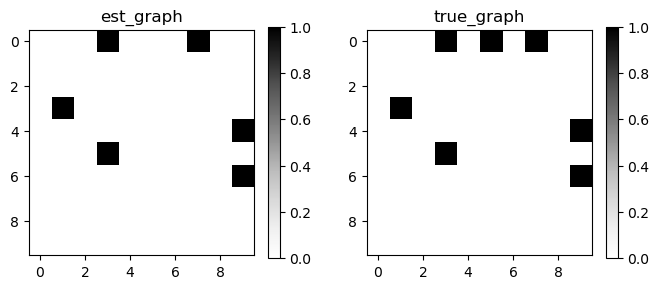

{'fdr': 0.0,
 'tpr': 0.8571,
 'fpr': 0.0,
 'shd': 1,
 'nnz': 6,
 'precision': 1.0,
 'recall': 0.8571,
 'F1': 0.9231,
 'gscore': 0.8571}

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import load_dataset
from castle.algorithms import TTPM
    # Data Simulation for TTPM
X, true_causal_matrix, topology_matrix = load_dataset('THP_Test')
ttpm = TTPM(topology_matrix, max_hop=2)
ttpm.learn(X)
causal_matrix = ttpm.causal_matrix
    # plot est_dag and true_dag
GraphDAG(ttpm.causal_matrix, true_causal_matrix)
    # calculate accuracy
ret_metrix = MetricsDAG(ttpm.causal_matrix, true_causal_matrix)
ret_metrix.metrics

# Loading data

In [ ]:
import numpy as np
from castle.algorithms.anm import ANMNonlinear
# np.random.seed(1)
# x = np.random.rand(500, 2)
data = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
x = data['x']
true_dag = data['y']
rank = np.linalg.matrix_rank(true_dag)

In [ ]:
x

array([[  0.867,   1.924,  -6.816,  -2.305,  -7.145,   2.09 ],
       [  0.698,   0.991,  -3.66 ,  -0.943,  -6.728,   0.86 ],
       [ -0.512,   0.381,   0.982,   0.409,   3.64 ,   0.787],
       ...,
       [  3.665,   0.944,  -2.667,   0.546, -12.22 ,  -1.127],
       [ -0.626,   0.606,   0.419,  -1.02 ,   3.479,   1.406],
       [ -1.361,   0.135,  -1.56 ,  -1.479,   0.074,   1.162]])

In [ ]:
x[:, [1]]

array([[1.924],
       [0.991],
       [0.381],
       ...,
       [0.944],
       [0.606],
       [0.135]])

In [ ]:
true_dag

array([[0, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

# Test for linear_gauss_6nodes_15edge

In [ ]:
import numpy as np
data = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
x_ = data['x']
true_dag = data['y']
x = x_[:, [0]]
y = x_[:, [1]]